In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_presplit_znorm_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_znorm_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_znorm_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 12:30:24 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:30:24 pyobsbox.generator INFO: shuffle: True
Feb/23 12:30:24 pyobsbox.generator INFO: batch_size: 8192
Feb/23 12:30:24 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 12:30:24 pyobsbox.generator INFO: n_bunches: 256
Feb/23 12:30:24 pyobsbox.generator INFO: __len__: 1036
Feb/23 12:30:24 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 12:30:24 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 12:30:24 pyobsbox.generator INFO: normalization: znorm
Feb/23 12:30:24 pyobsbox.generator INFO: normalization_pre_split: True
Feb/23 12:30:24 pyobsbox.generator INFO: normalization_kwargs: {}
Feb/23 12:30:24 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:30:24 pyobsbox.generator INFO: shuffle: True
Feb/23 12:30:24 pyobsbox.generator INFO: batch_

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265216, 11)


type  fill  beam plane  q           date_time  \
7245737  Inst  6254     1     h  7 2017-09-29 05:26:15   
6889021  Inst  6703     1     h  7 2018-05-20 03:39:14   
1617656  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141839  Inst  6953     1     h  7 2018-07-21 06:32:07   
593493   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245737  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/...        292   
6889021  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...        396   
1617656  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141839  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593493   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245737        518.0         284.0      65536  
6889021        426.0         275.0      65536  
1617656       1712.0        1245.0      65536  
6141839        106.0          57.0      65536  
593493        2009.0        1100.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
9020904   Inst  6266     1     h  7 2017-10-03 05:37:14   
2349835   Inst  6984     1     h  7 2018-07-26 21:32:50   
2806408   Inst  7443     1     h  7 2018-11-14 02:37:08   
10088293  Inst  6890     1     h  7 2018-07-06 00:35:14   
3583762   Inst  6890     1     h  7 2018-07-06 10:34:15   

                                                       file  n_bunches  \
9020904   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6266/...       1836   
2349835   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/...        286   
2806408   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/...        108   
10088293  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/...       1452   
3583762   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/...       1452   

          bunch_index  bunch_number  ts_length  
9020904          62.0          12.0      65536  
2349835         503.0         113.0      65536  
2806408         513.0          93.0      65536  
10088293        846.0         346.0      65536  
3583762        3158.0        1337.0      65536

# Loss functions

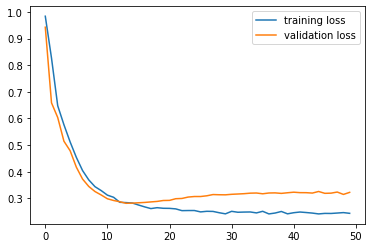

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 52s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 6s 1s/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

Text(0.5, 1.0, 'train dataset')

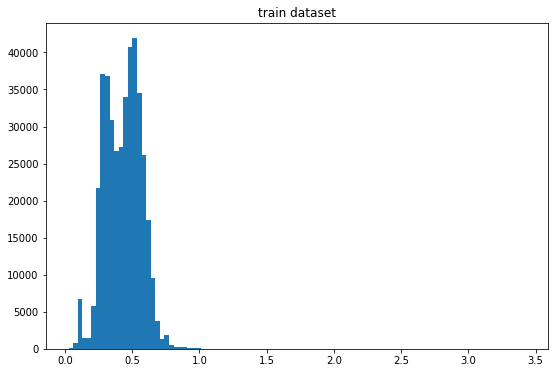

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
# plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.5024543887829472

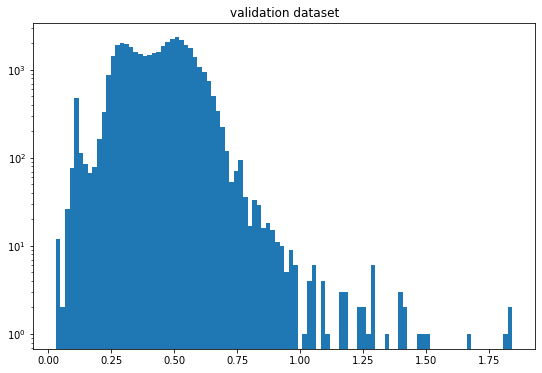

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.5010811237963393

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([361763, 309490, 340780, ..., 144241, 146761, 142448])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  361763
MAE:  3.4221588370591016
n_bunches        732
bunch_index     1992
bunch_number     549
Name: 5836417, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h53m00s.h5


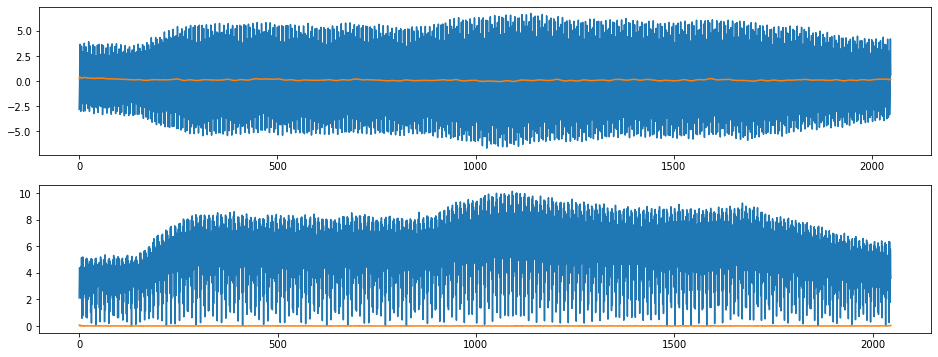

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  361763
MAE:  3.4221588370591016
n_bunches        732
bunch_index     1992
bunch_number     549
Name: 5836417, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h53m00s.h5


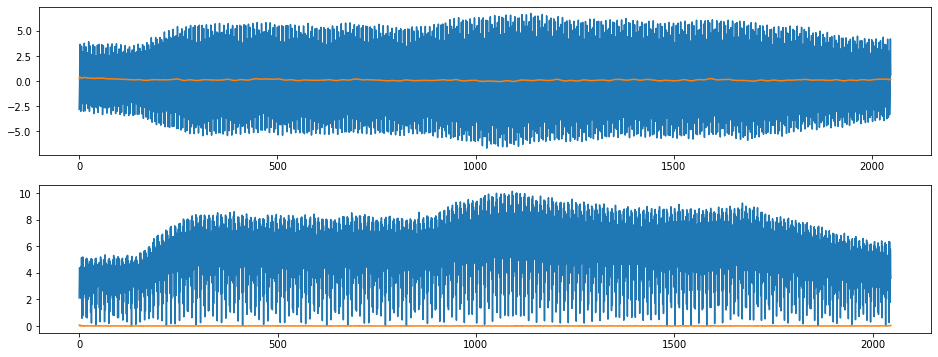

index:  309490
MAE:  3.174269651296866
n_bunches       924
bunch_index     520
bunch_number    374
Name: 5406894, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7239/instability_data/07239_Inst_B1H_Q7_20180930_12h13m34s.h5


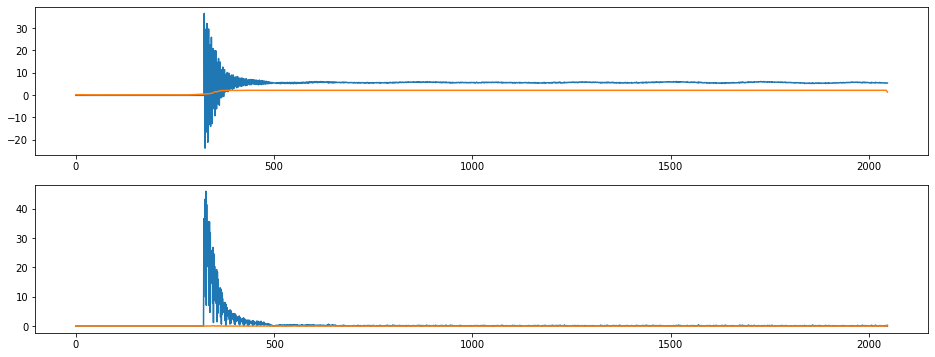

index:  340780
MAE:  2.6361842766013037
n_bunches       2556
bunch_index     2912
bunch_number    2159
Name: 5652303, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_13h14m14s.h5


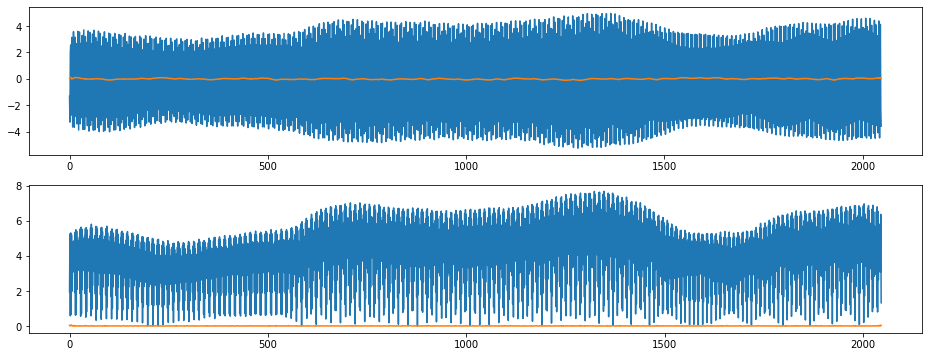

index:  284490
MAE:  2.595263338765776
n_bunches       156
bunch_index     208
bunch_number     25
Name: 2241391, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6805/instability_data/06805_Inst_B1H_Q7_20180616_01h50m35s.h5


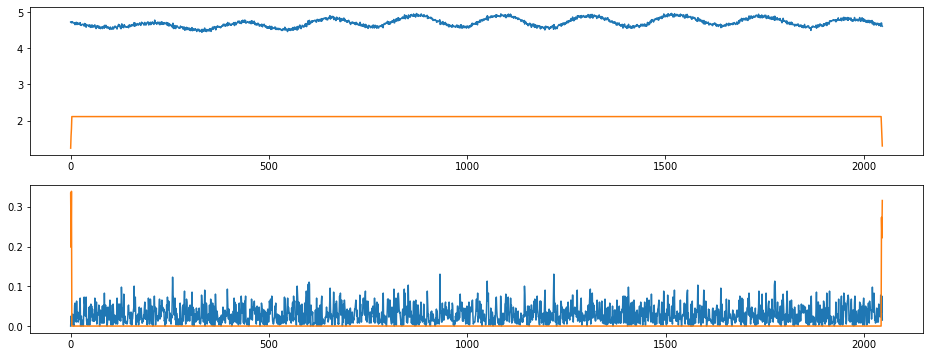

index:  234588
MAE:  2.5763358932926588
n_bunches        408
bunch_index     1929
bunch_number     246
Name: 849308, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_02h12m44s.h5


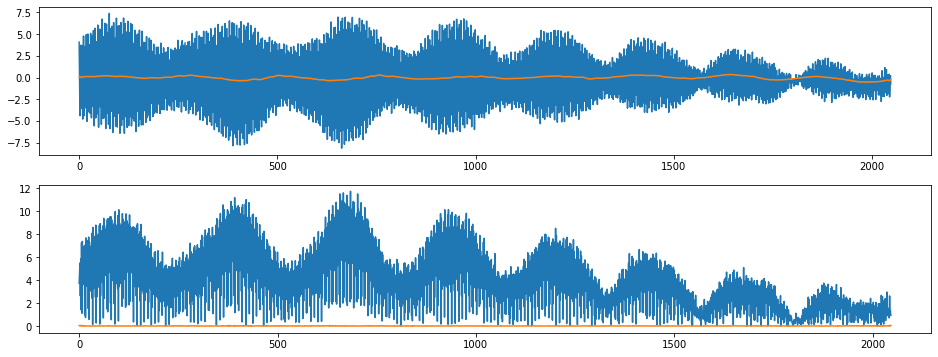

index:  275276
MAE:  2.5239940678816333
n_bunches        460
bunch_index     3185
bunch_number     401
Name: 8294780, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_04h57m14s.h5


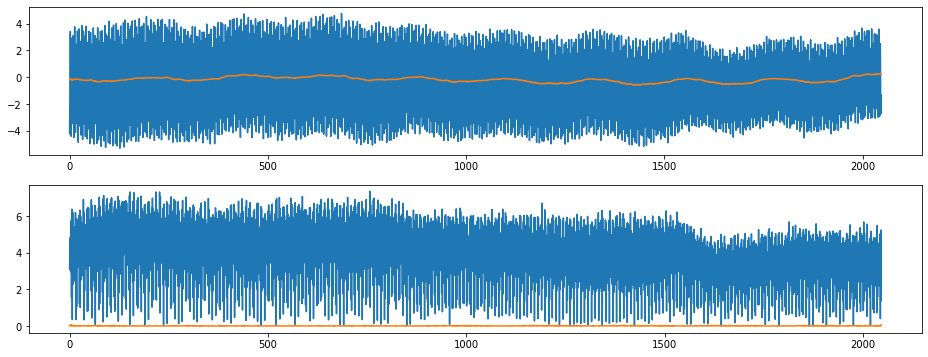

index:  201180
MAE:  2.429051198571118
n_bunches       300
bunch_index     779
bunch_number    217
Name: 7184266, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h41m50s.h5


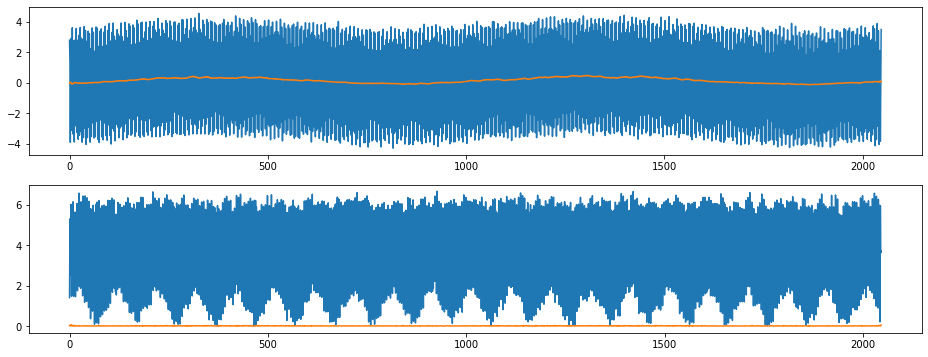

index:  196773
MAE:  2.423848357014733
n_bunches        987
bunch_index     3179
bunch_number     939
Name: 3676638, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_08h56m14s.h5


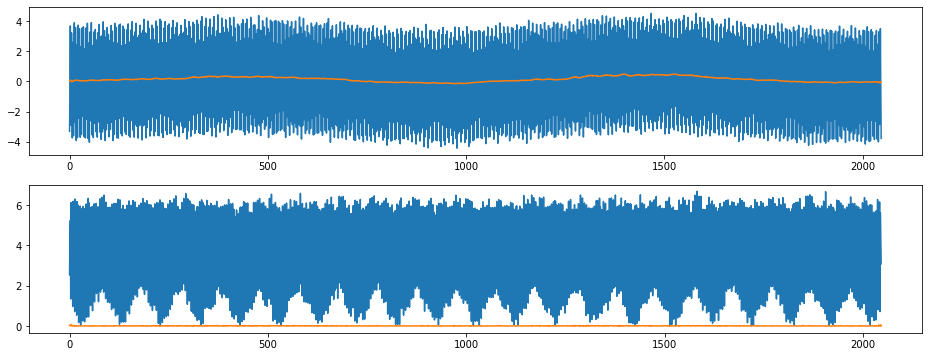

index:  200869
MAE:  2.423535531618597
n_bunches        224
bunch_index     2833
bunch_number     200
Name: 713577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6194/instability_data/06194_Inst_B1H_Q7_20170913_10h45m14s.h5


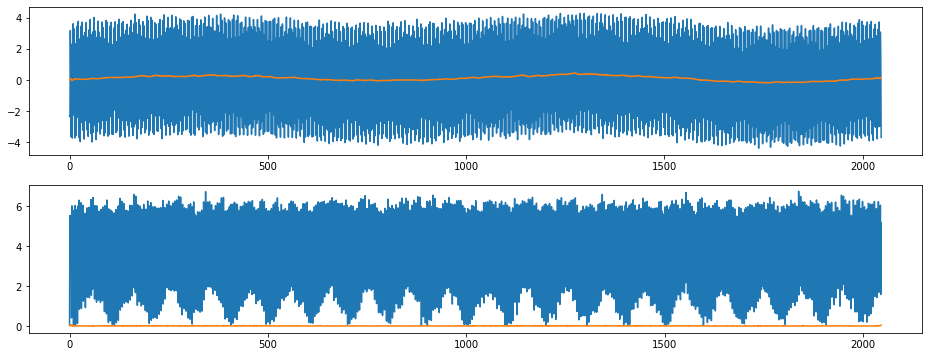

index:  372175
MAE:  2.393822857608302
n_bunches       2556
bunch_index     3016
bunch_number    2249
Name: 1558689, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h51m14s.h5


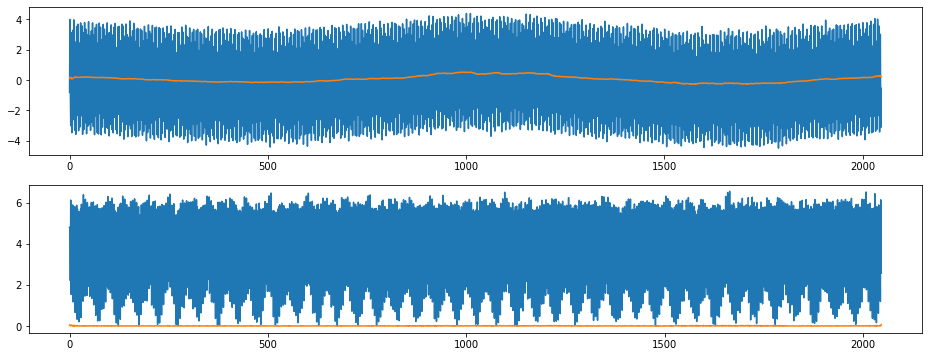

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  142448
MAE:  0.02715366464496862
n_bunches       156
bunch_index     237
bunch_number     54
Name: 9753994, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h36m14s.h5


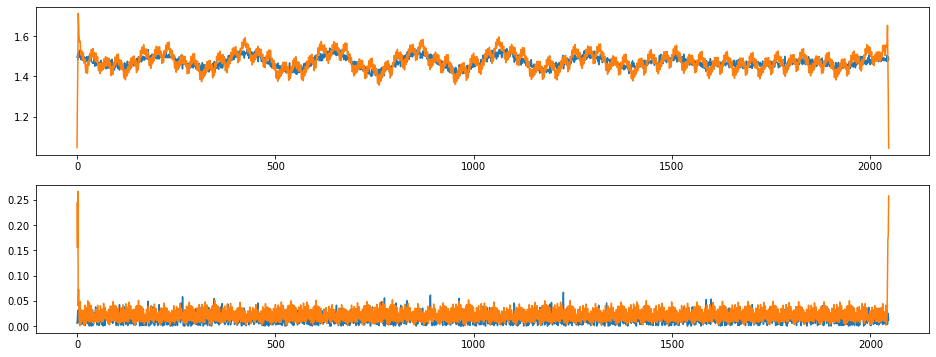

index:  146761
MAE:  0.027365796414137195
n_bunches          6
bunch_index     2554
bunch_number       5
Name: 5002039, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7281/instability_data/07281_Inst_B1H_Q7_20181012_02h53m14s.h5


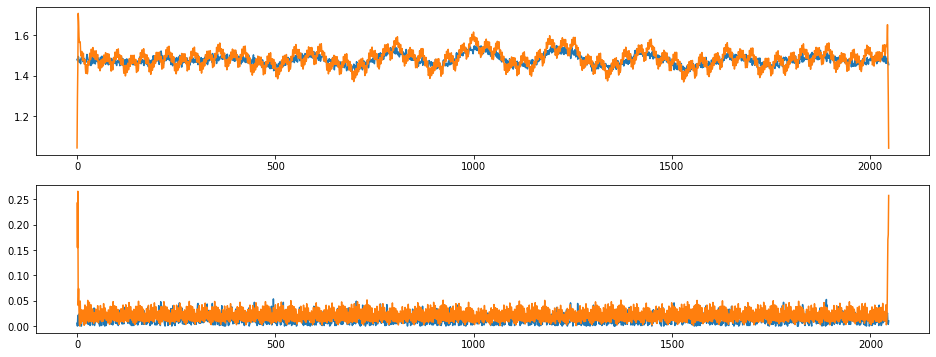

index:  144241
MAE:  0.02770350005702539
n_bunches       1452
bunch_index      524
bunch_number     209
Name: 4975003, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_12h47m14s.h5


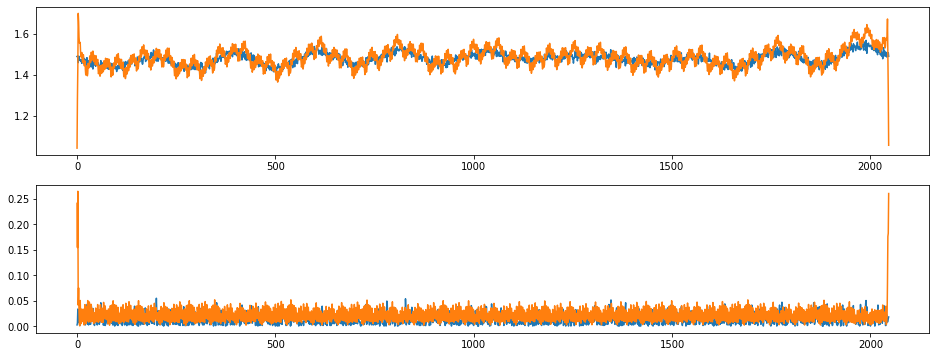

index:  145202
MAE:  0.027789231066094
n_bunches       1868
bunch_index      516
bunch_number     279
Name: 9851010, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_15h11m18s.h5


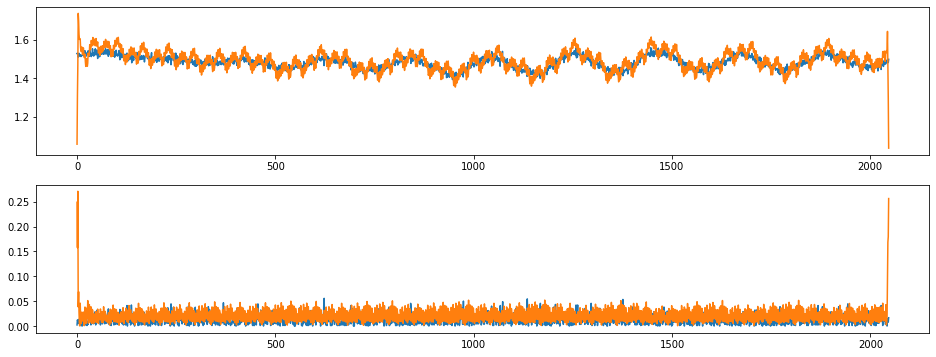

index:  136539
MAE:  0.02806534474208055
n_bunches        648
bunch_index     3208
bunch_number     602
Name: 208704, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_12h37m14s.h5


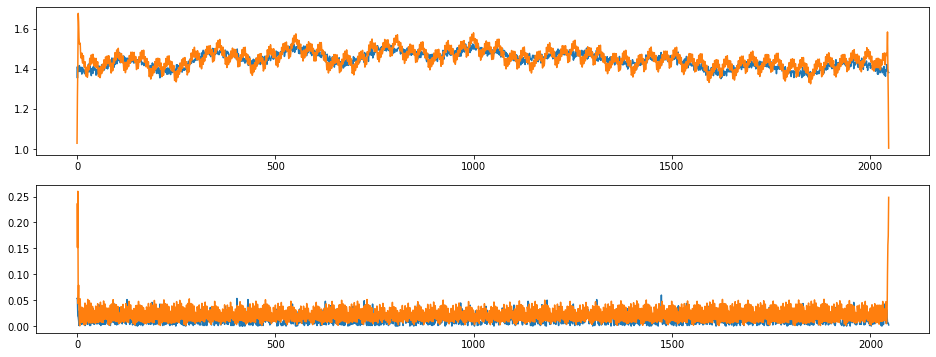

index:  132360
MAE:  0.028080686815169273
n_bunches        216
bunch_index     1752
bunch_number     205
Name: 10863958, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7023/instability_data/07023_Inst_B1H_Q7_20180805_07h20m20s.h5


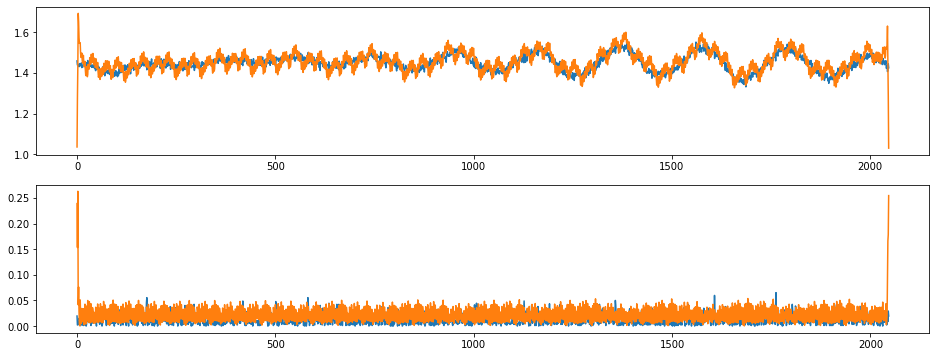

index:  296428
MAE:  0.028239924984626238
n_bunches       1868
bunch_index      415
bunch_number     216
Name: 7237495, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_14h47m13s.h5


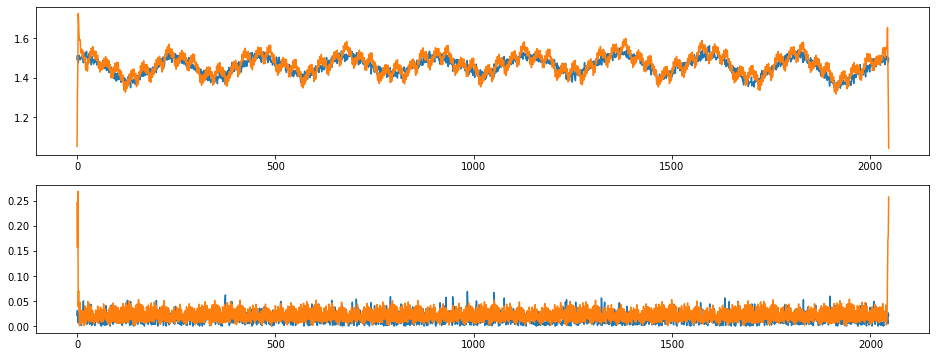

index:  301038
MAE:  0.028750969688078828
n_bunches       684
bunch_index     575
bunch_number    416
Name: 10325805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6904/instability_data/06904_Inst_B1H_Q7_20180708_20h39m27s.h5


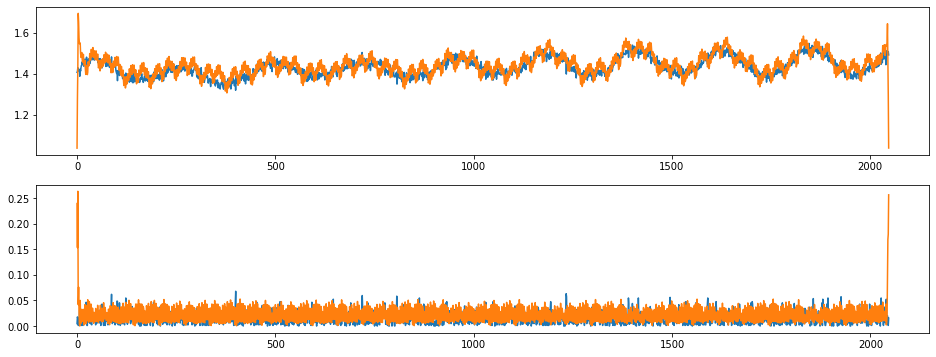

index:  133960
MAE:  0.028855611753691952
n_bunches       44
bunch_index     47
bunch_number    14
Name: 1904962, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6354/instability_data/06354_Inst_B1H_Q7_20171101_17h41m14s.h5


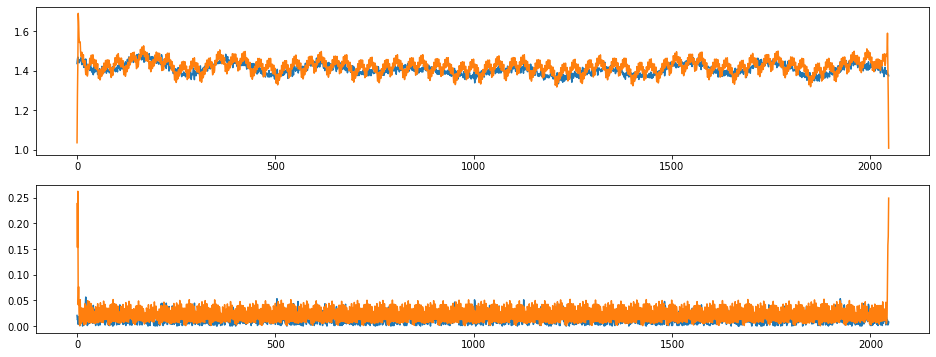

index:  296272
MAE:  0.029520194602256987
n_bunches       649
bunch_index     185
bunch_number     61
Name: 6904338, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6858/instability_data/06858_Inst_B1H_Q7_20180628_07h11m43s.h5


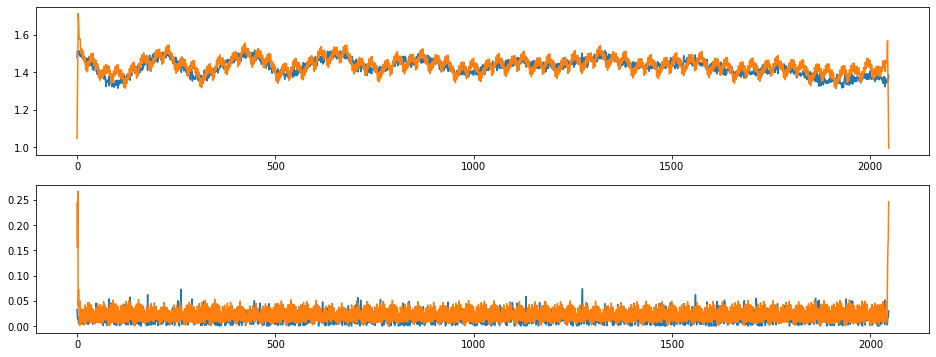

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  17853
MAE:  0.5024546770980336
n_bunches       1836
bunch_index     1584
bunch_number     830
Name: 10680222, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6389/instability_data/06389_Inst_B1H_Q7_20171115_12h20m14s.h5


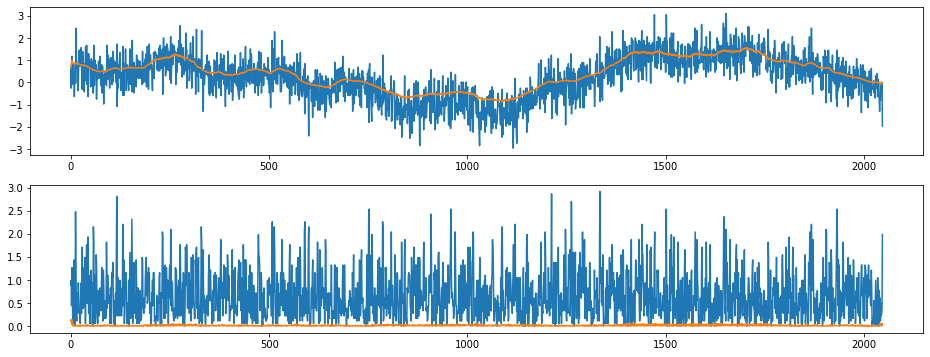

index:  208123
MAE:  0.5024540713196789
n_bunches       1
bunch_index     0
bunch_number    0
Name: 7041281, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6233/instability_data/06233_Inst_B1H_Q7_20170923_07h23m52s.h5


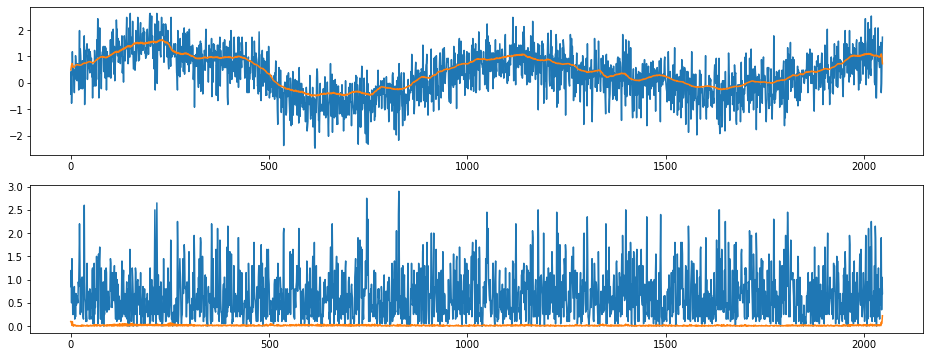

index:  244955
MAE:  0.5024549573005276
n_bunches       1916
bunch_index       10
bunch_number       3
Name: 10216364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_04h35m14s.h5


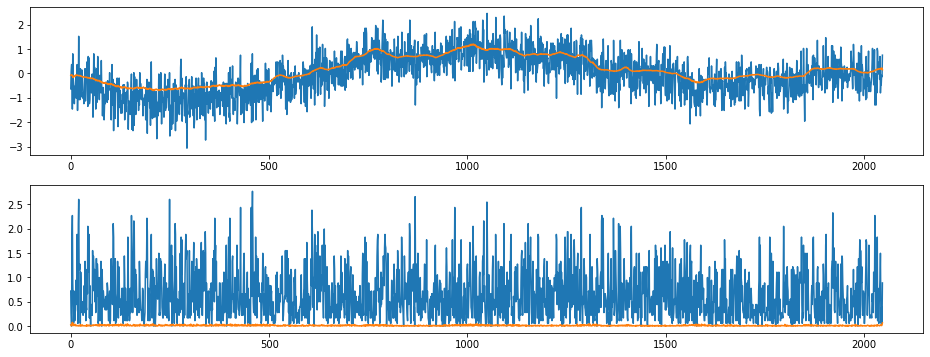

index:  35486
MAE:  0.5024537613764926
n_bunches       120
bunch_index     150
bunch_number     94
Name: 7068008, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7311/instability_data/07311_Inst_B1H_Q7_20181017_22h19m13s.h5


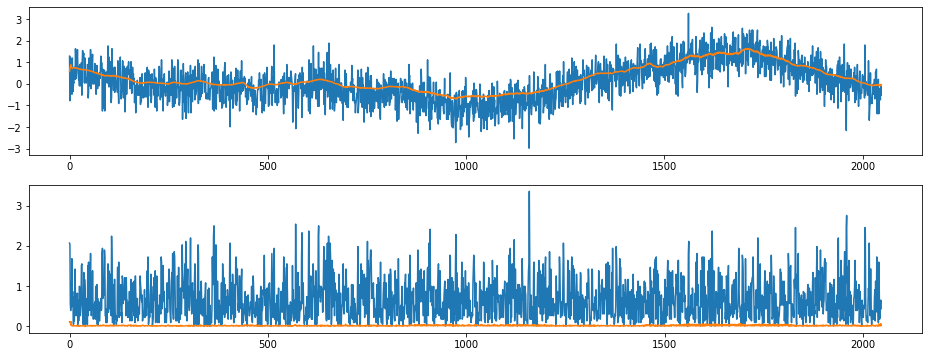

index:  405160
MAE:  0.502455266493745
n_bunches       20
bunch_index     12
bunch_number     3
Name: 9152823, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7462/instability_data/07462_Inst_B1H_Q7_20181121_20h04m16s.h5


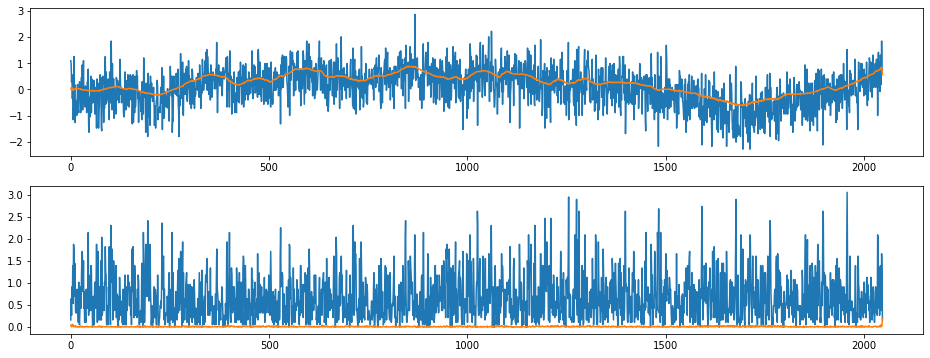

index:  152008
MAE:  0.5024559248946487
n_bunches       540
bunch_index      80
bunch_number     31
Name: 6119707, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7316/instability_data/07316_Inst_B1H_Q7_20181019_06h49m24s.h5


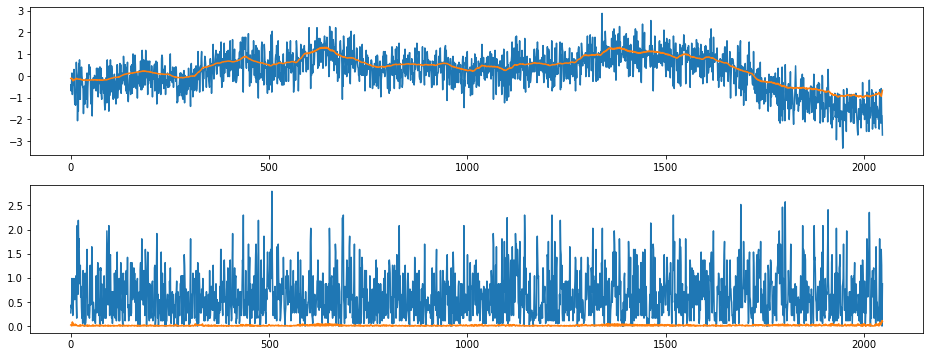

index:  64942
MAE:  0.5024524513751215
n_bunches        152
bunch_index     1030
bunch_number      44
Name: 4124380, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7300/instability_data/07300_Inst_B1H_Q7_20181014_09h49m19s.h5


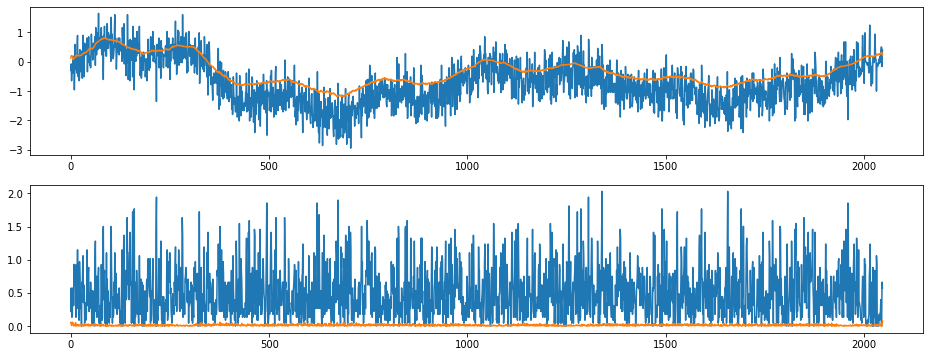

index:  262267
MAE:  0.5024577041284963
n_bunches        652
bunch_index     1182
bunch_number     639
Name: 7553965, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_08h18m48s.h5


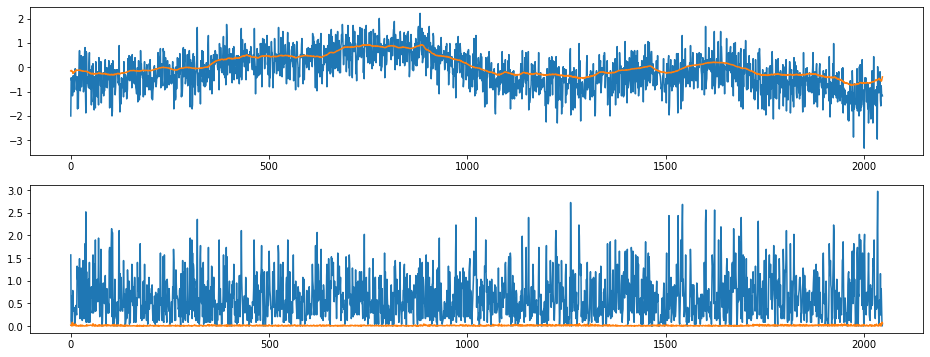

index:  393645
MAE:  0.5024508379632973
n_bunches       2460
bunch_index      148
bunch_number      86
Name: 1663033, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_17h30m37s.h5


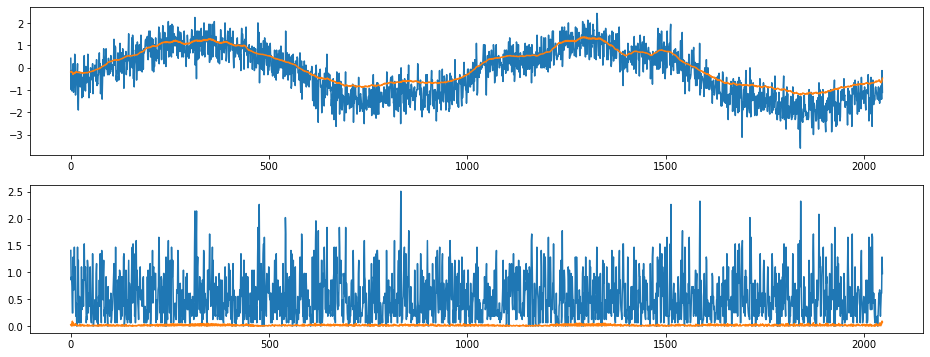

index:  184864
MAE:  0.5024507656335357
n_bunches        908
bunch_index     1160
bunch_number     625
Name: 7027766, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_02h21m30s.h5


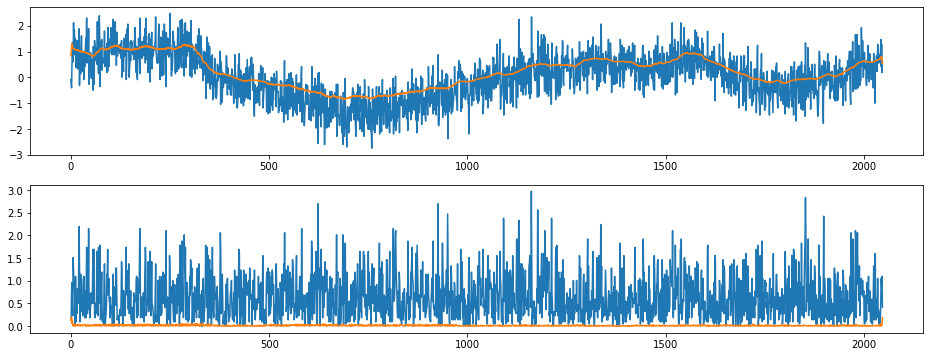

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  336147
MAE:  0.6000008421290817
n_bunches       1227
bunch_index      265
bunch_number     127
Name: 1858801, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_08h21m14s.h5


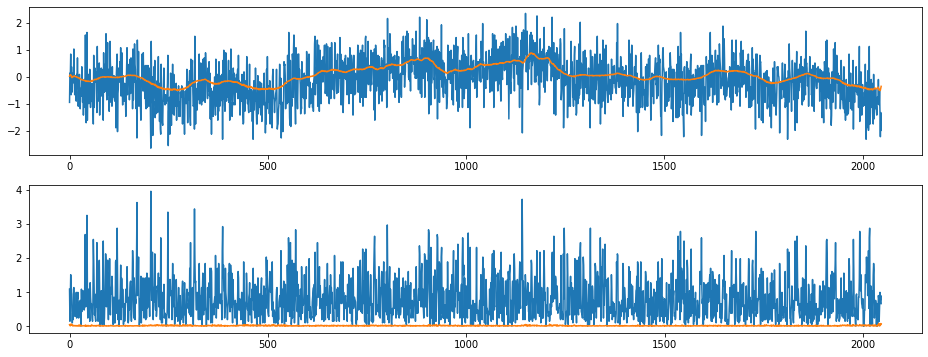

index:  43303
MAE:  0.6000010076166298
n_bunches       852
bunch_index     311
bunch_number    127
Name: 3567045, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/instability_data/07365_Inst_B1H_Q7_20181026_23h14m45s.h5


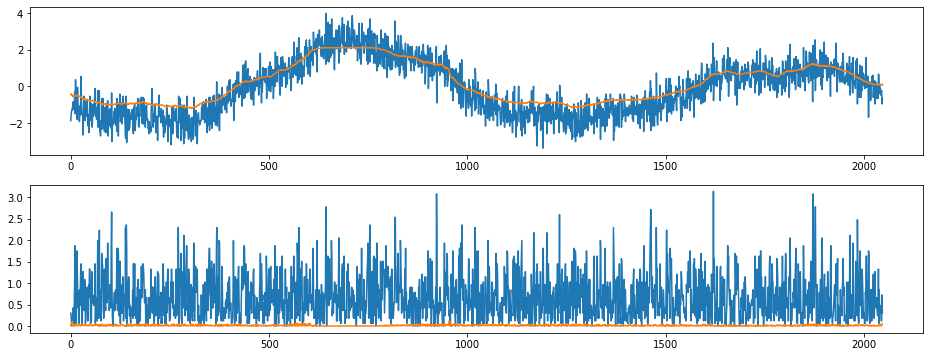

index:  36430
MAE:  0.5999979304876677
n_bunches       1068
bunch_index      234
bunch_number     147
Name: 343734, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7088/instability_data/07088_Inst_B1H_Q7_20180826_04h27m50s.h5


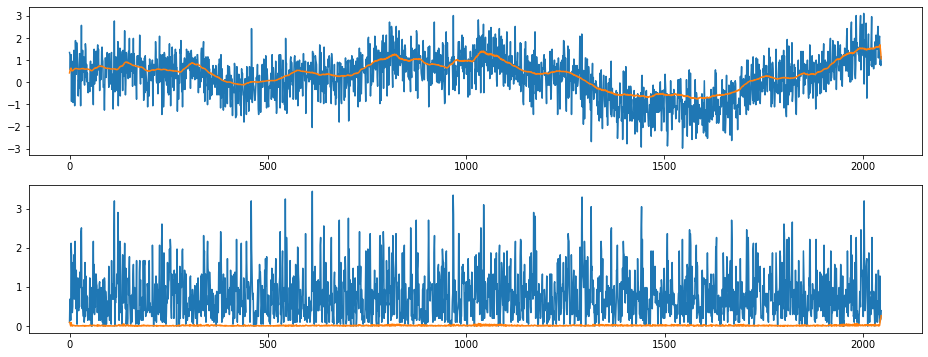

index:  34946
MAE:  0.5999977267419567
n_bunches       1868
bunch_index     1862
bunch_number    1001
Name: 3443515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_13h18m13s.h5


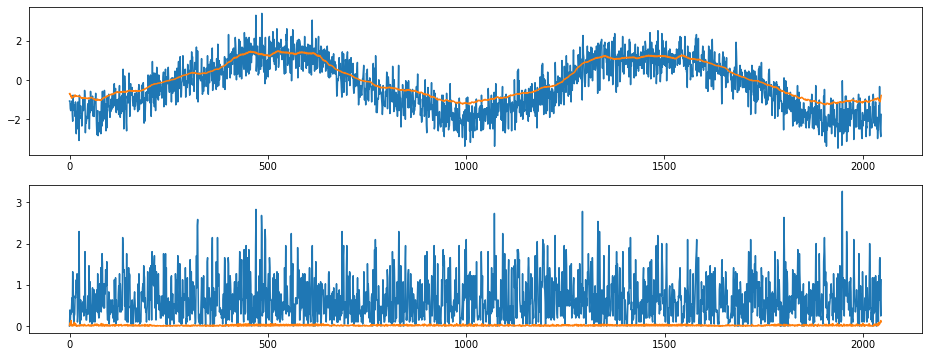

index:  259004
MAE:  0.599997152782948
n_bunches       252
bunch_index     331
bunch_number    230
Name: 11353794, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7045/instability_data/07045_Inst_B1H_Q7_20180811_23h11m32s.h5


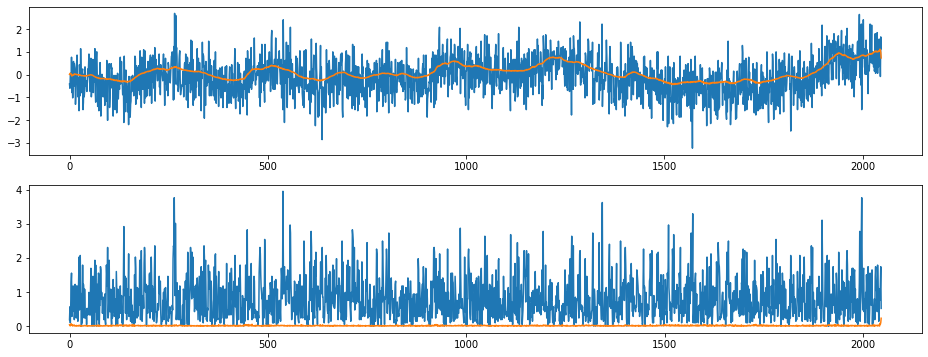

index:  330441
MAE:  0.5999965188648284
n_bunches       2175
bunch_index      571
bunch_number     412
Name: 5780662, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_13h50m14s.h5


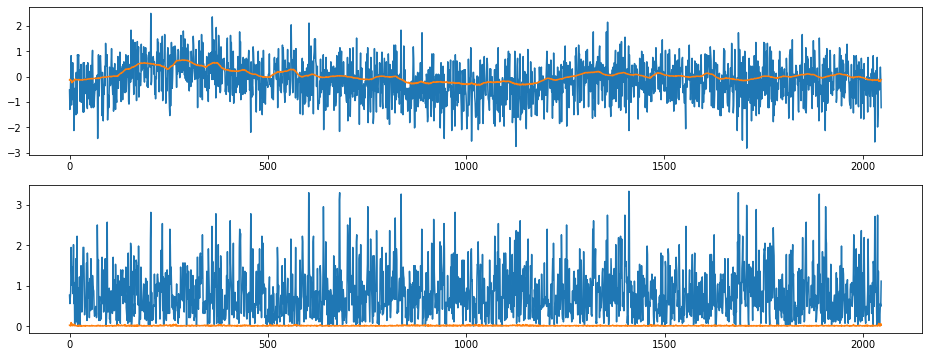

index:  228728
MAE:  0.599996474902049
n_bunches       877
bunch_index     314
bunch_number    207
Name: 8507225, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_08h51m20s.h5


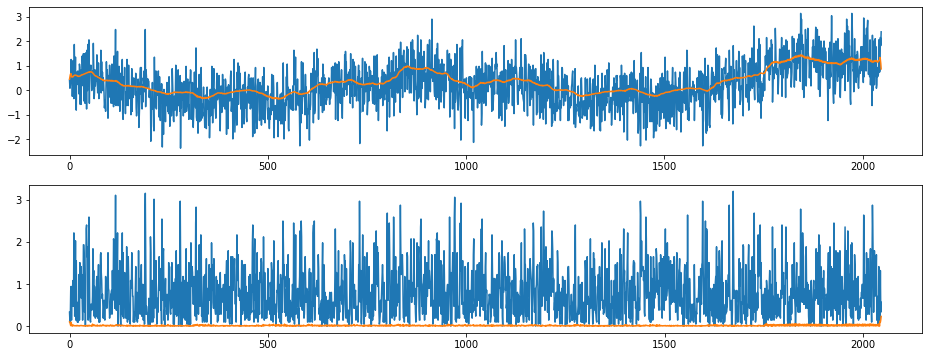

index:  90047
MAE:  0.5999954136707264
n_bunches       1596
bunch_index     2125
bunch_number    1586
Name: 10963242, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170916_23h38m53s.h5


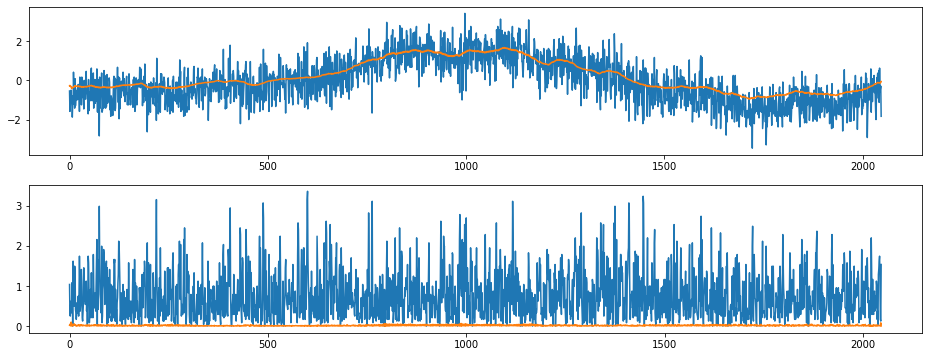

index:  321326
MAE:  0.5999953745130858
n_bunches       292
bunch_index     100
bunch_number     46
Name: 8730770, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6252/instability_data/06252_Inst_B1H_Q7_20170927_21h21m46s.h5


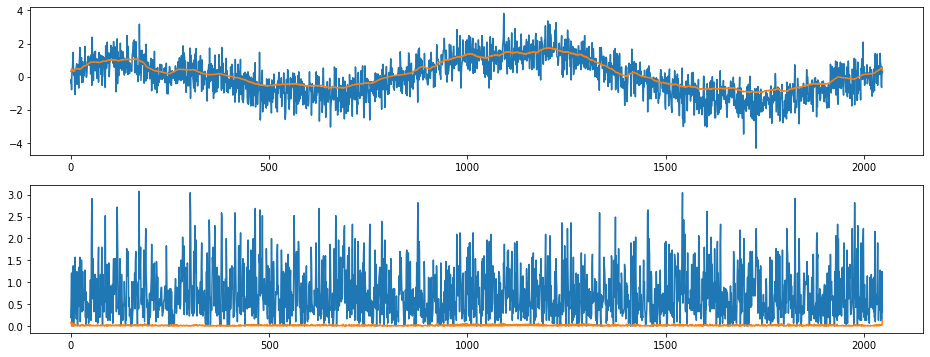

index:  368512
MAE:  0.5999940443689413
n_bunches       1836
bunch_index     1494
bunch_number     787
Name: 8325921, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6266/instability_data/06266_Inst_B1H_Q7_20171003_04h21m14s.h5


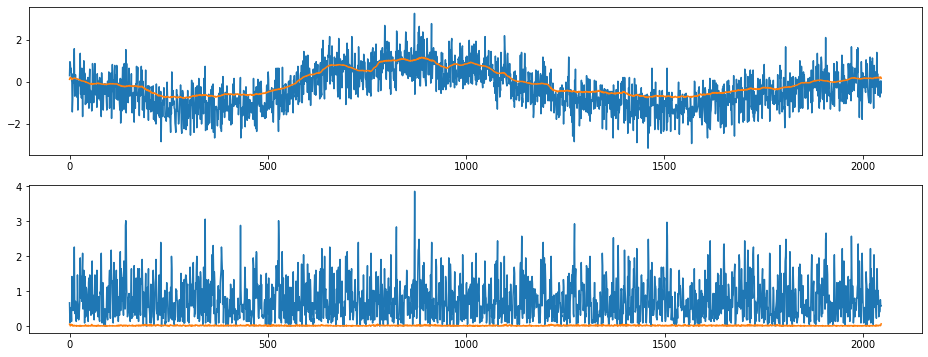

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

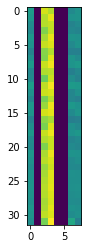

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  142448
MAE:  0.02715366464496862
n_bunches       156
bunch_index     237
bunch_number     54
Name: 9753994, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h36m14s.h5


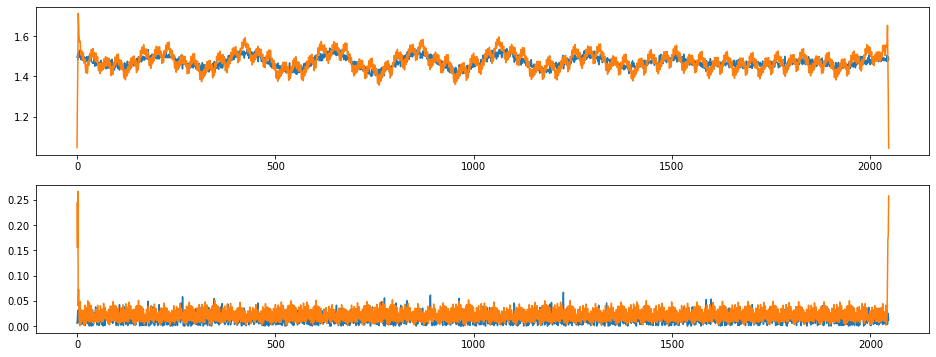

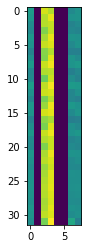

index:  146761
MAE:  0.027365796414137195
n_bunches          6
bunch_index     2554
bunch_number       5
Name: 5002039, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7281/instability_data/07281_Inst_B1H_Q7_20181012_02h53m14s.h5


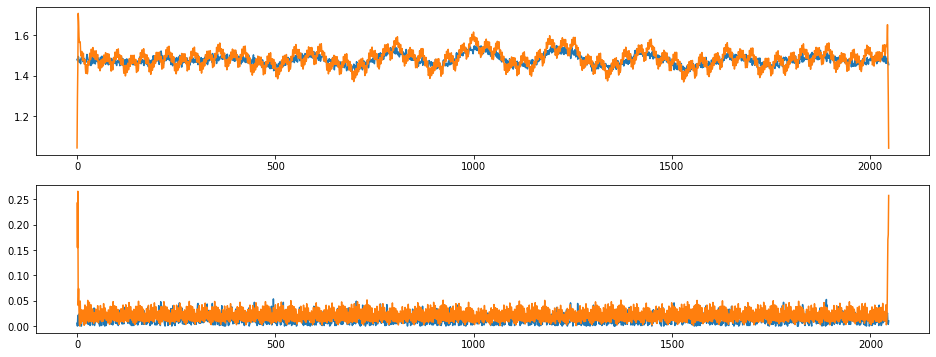

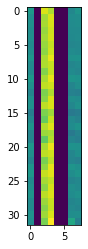

index:  144241
MAE:  0.02770350005702539
n_bunches       1452
bunch_index      524
bunch_number     209
Name: 4975003, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_12h47m14s.h5


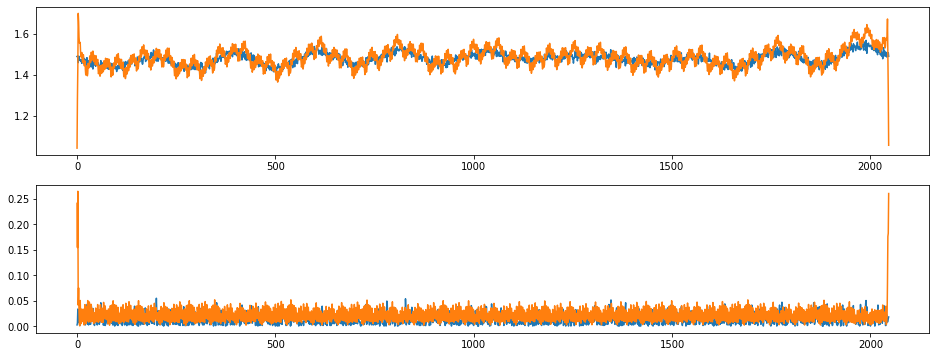

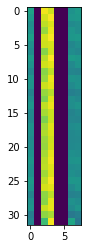

index:  145202
MAE:  0.027789231066094
n_bunches       1868
bunch_index      516
bunch_number     279
Name: 9851010, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_15h11m18s.h5


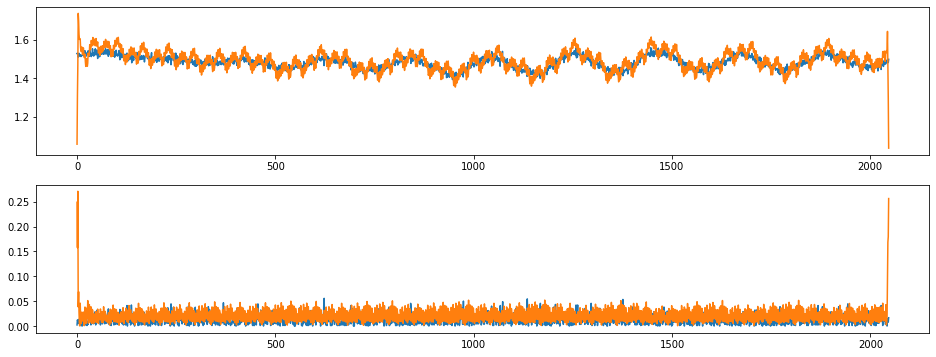

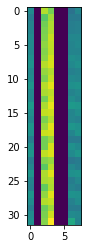

index:  136539
MAE:  0.02806534474208055
n_bunches        648
bunch_index     3208
bunch_number     602
Name: 208704, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_12h37m14s.h5


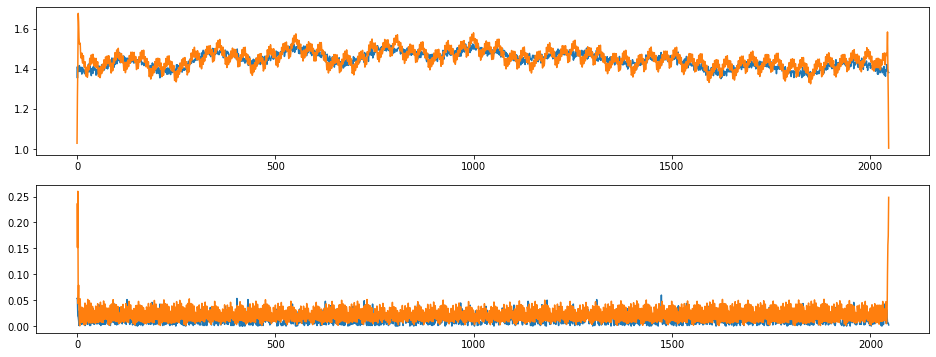

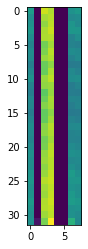

index:  132360
MAE:  0.028080686815169273
n_bunches        216
bunch_index     1752
bunch_number     205
Name: 10863958, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7023/instability_data/07023_Inst_B1H_Q7_20180805_07h20m20s.h5


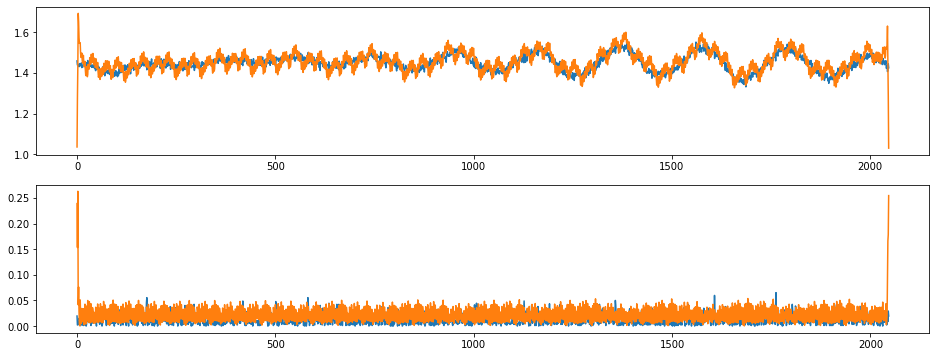

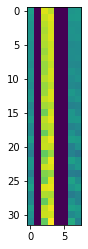

index:  296428
MAE:  0.028239924984626238
n_bunches       1868
bunch_index      415
bunch_number     216
Name: 7237495, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_14h47m13s.h5


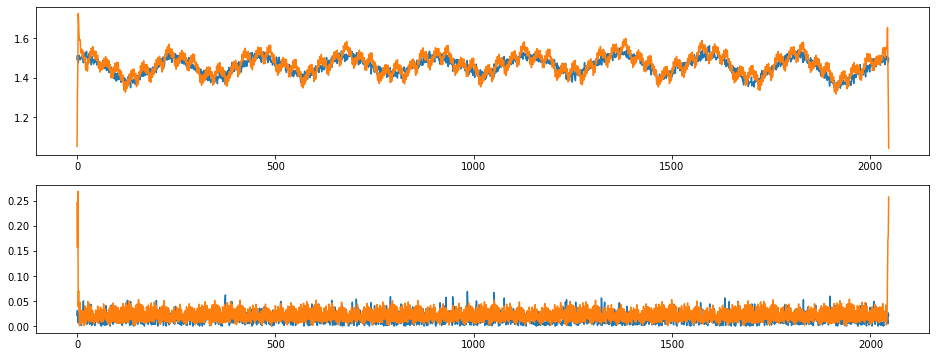

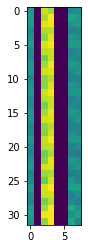

index:  301038
MAE:  0.028750969688078828
n_bunches       684
bunch_index     575
bunch_number    416
Name: 10325805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6904/instability_data/06904_Inst_B1H_Q7_20180708_20h39m27s.h5


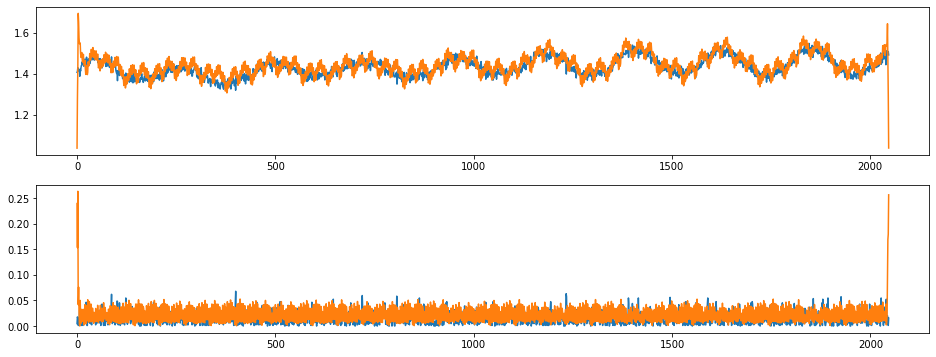

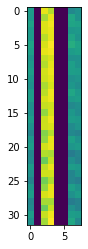

index:  133960
MAE:  0.028855611753691952
n_bunches       44
bunch_index     47
bunch_number    14
Name: 1904962, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6354/instability_data/06354_Inst_B1H_Q7_20171101_17h41m14s.h5


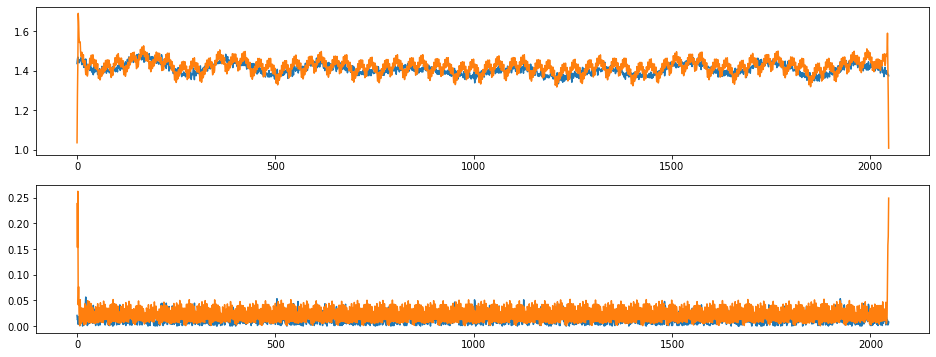

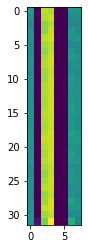

index:  296272
MAE:  0.029520194602256987
n_bunches       649
bunch_index     185
bunch_number     61
Name: 6904338, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6858/instability_data/06858_Inst_B1H_Q7_20180628_07h11m43s.h5


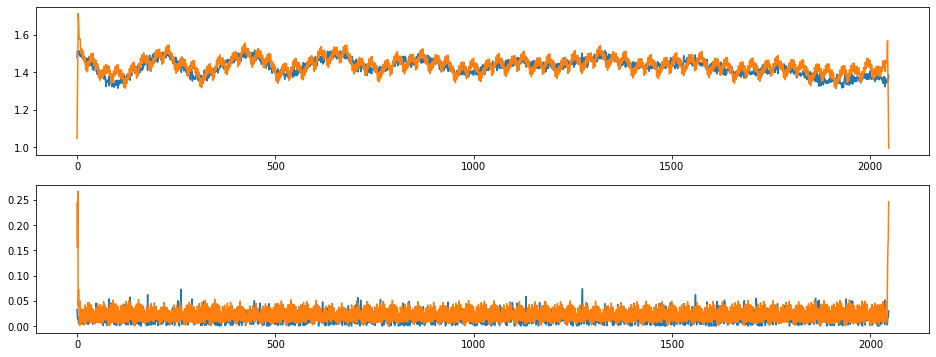

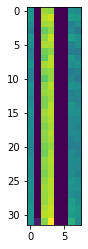

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  361763
MAE:  3.4221588370591016
n_bunches        732
bunch_index     1992
bunch_number     549
Name: 5836417, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h53m00s.h5


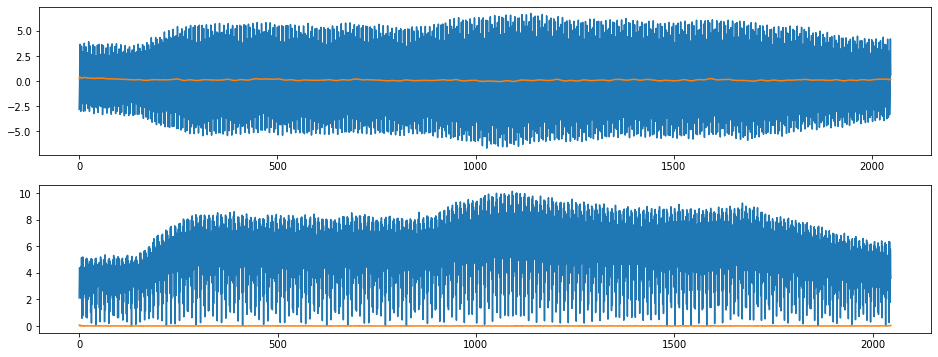

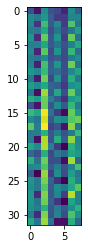

index:  309490
MAE:  3.174269651296866
n_bunches       924
bunch_index     520
bunch_number    374
Name: 5406894, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7239/instability_data/07239_Inst_B1H_Q7_20180930_12h13m34s.h5


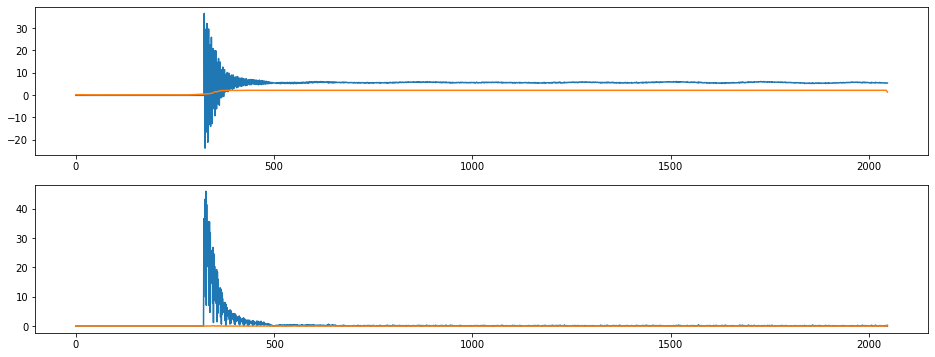

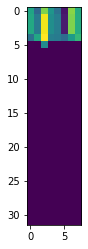

index:  340780
MAE:  2.6361842766013037
n_bunches       2556
bunch_index     2912
bunch_number    2159
Name: 5652303, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_13h14m14s.h5


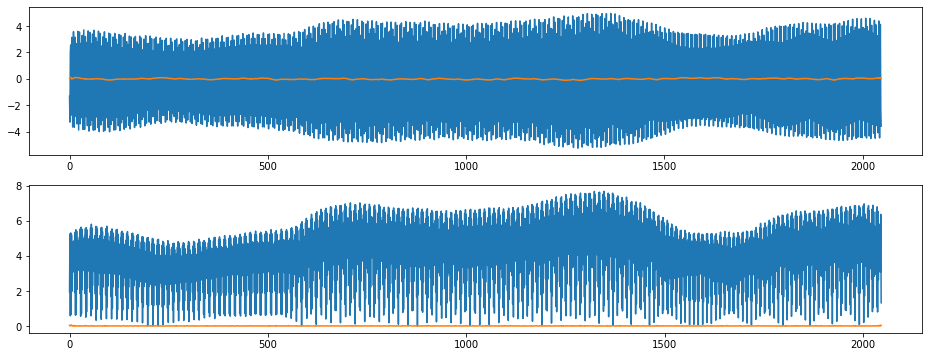

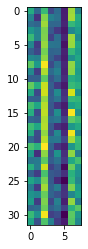

index:  284490
MAE:  2.595263338765776
n_bunches       156
bunch_index     208
bunch_number     25
Name: 2241391, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6805/instability_data/06805_Inst_B1H_Q7_20180616_01h50m35s.h5


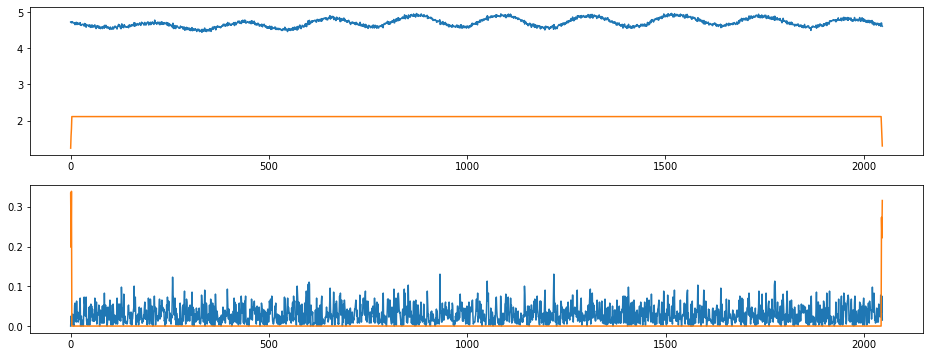

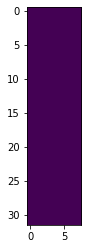

index:  234588
MAE:  2.5763358932926588
n_bunches        408
bunch_index     1929
bunch_number     246
Name: 849308, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_02h12m44s.h5


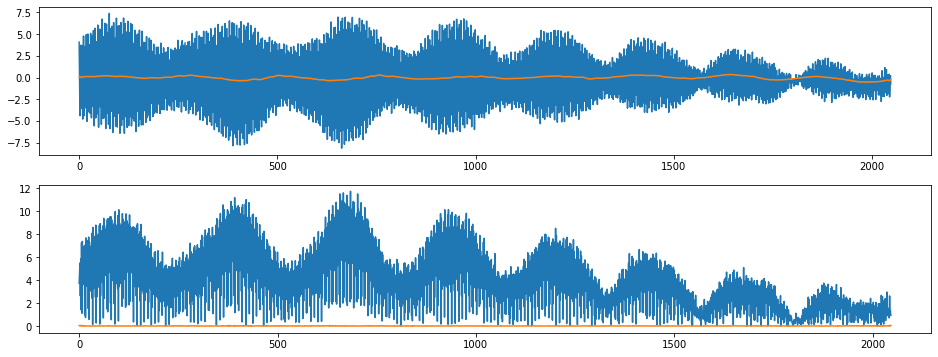

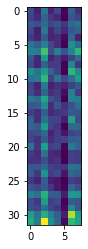

index:  275276
MAE:  2.5239940678816333
n_bunches        460
bunch_index     3185
bunch_number     401
Name: 8294780, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_04h57m14s.h5


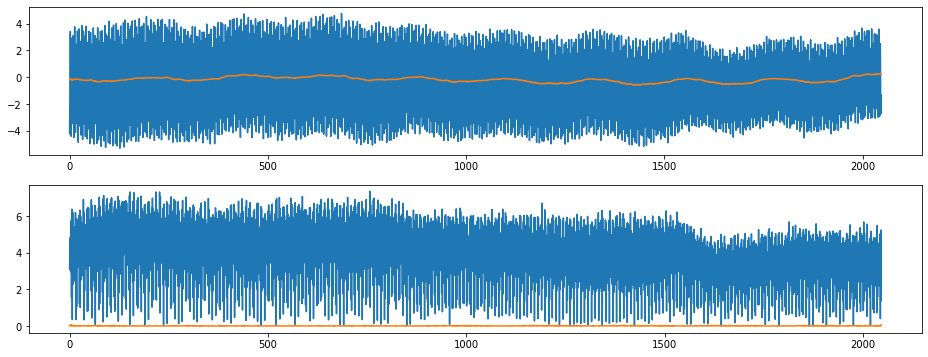

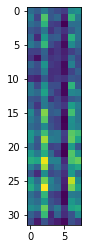

index:  201180
MAE:  2.429051198571118
n_bunches       300
bunch_index     779
bunch_number    217
Name: 7184266, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h41m50s.h5


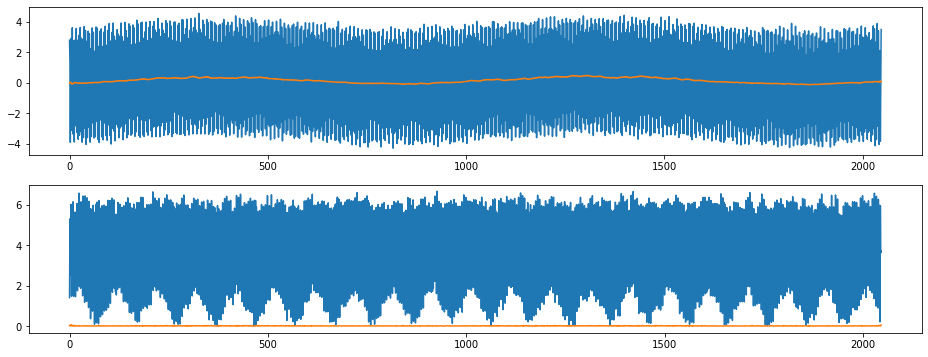

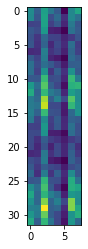

index:  196773
MAE:  2.423848357014733
n_bunches        987
bunch_index     3179
bunch_number     939
Name: 3676638, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_08h56m14s.h5


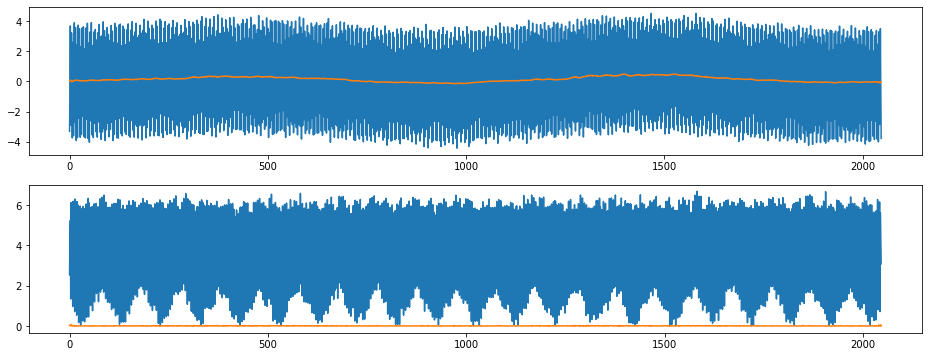

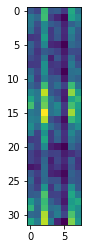

index:  200869
MAE:  2.423535531618597
n_bunches        224
bunch_index     2833
bunch_number     200
Name: 713577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6194/instability_data/06194_Inst_B1H_Q7_20170913_10h45m14s.h5


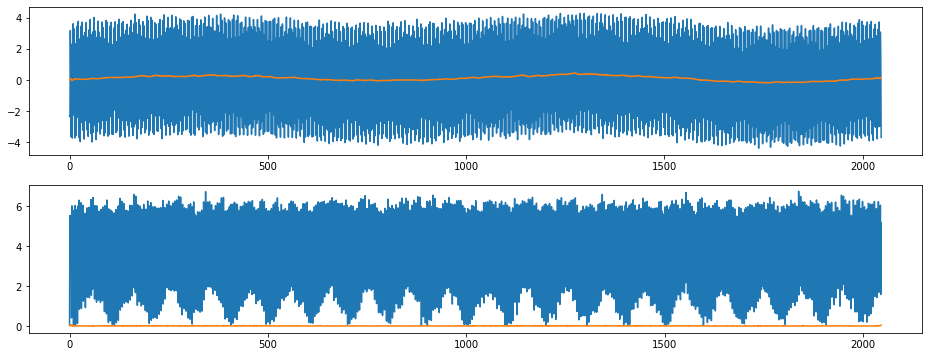

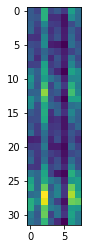

index:  372175
MAE:  2.393822857608302
n_bunches       2556
bunch_index     3016
bunch_number    2249
Name: 1558689, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h51m14s.h5


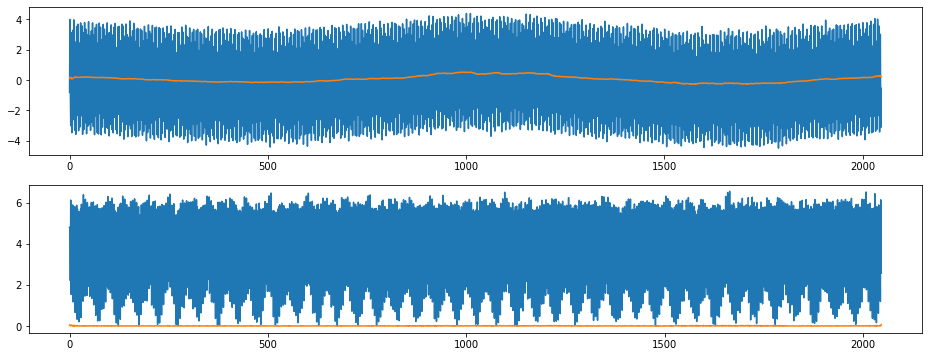

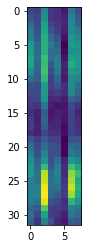

index:  375087
MAE:  2.384169155416286
n_bunches       72
bunch_index     23
bunch_number     7
Name: 8952349, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6595/instability_data/06595_Inst_B1H_Q7_20180422_20h50m03s.h5


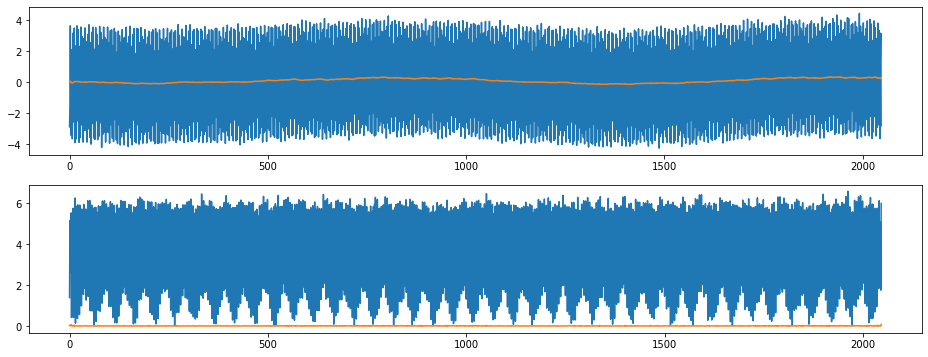

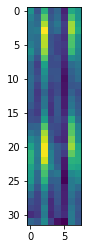

index:  372696
MAE:  2.3832957412048987
n_bunches       1868
bunch_index     1181
bunch_number     638
Name: 11169957, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6344/instability_data/06344_Inst_B1H_Q7_20171029_00h58m13s.h5


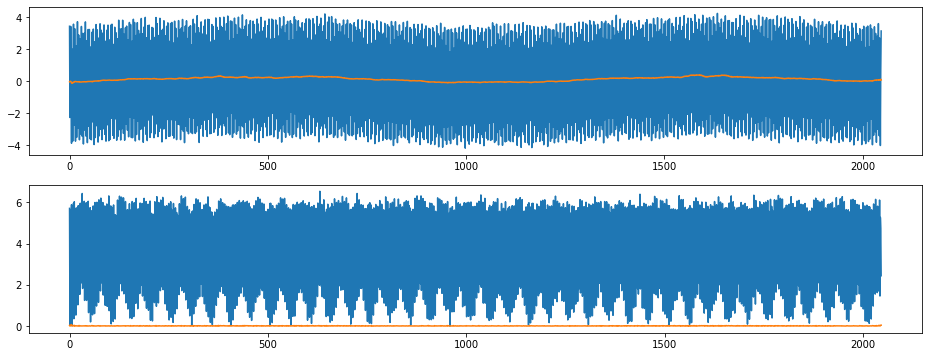

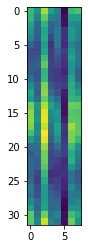

index:  406516
MAE:  2.337126460759738
n_bunches        408
bunch_index     1953
bunch_number     259
Name: 9744559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_03h44m41s.h5


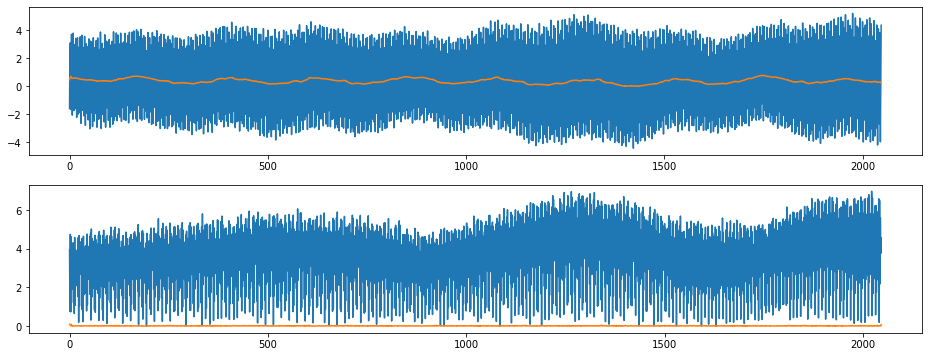

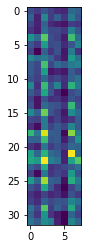

index:  112642
MAE:  2.3150947399586217
n_bunches       300
bunch_index      93
bunch_number     38
Name: 4815427, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6640/instability_data/06640_Inst_B1H_Q7_20180504_08h54m34s.h5


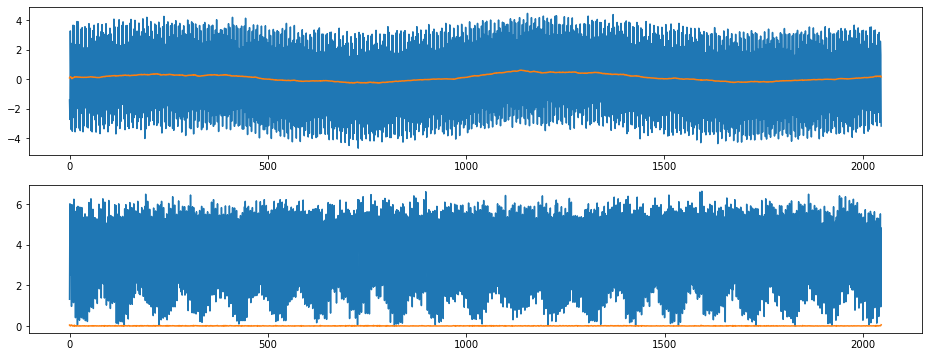

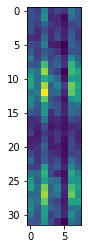

index:  109584
MAE:  2.313510622292503
n_bunches       268
bunch_index     402
bunch_number    182
Name: 146877, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6394/instability_data/06394_Inst_B1H_Q7_20171116_17h31m14s.h5


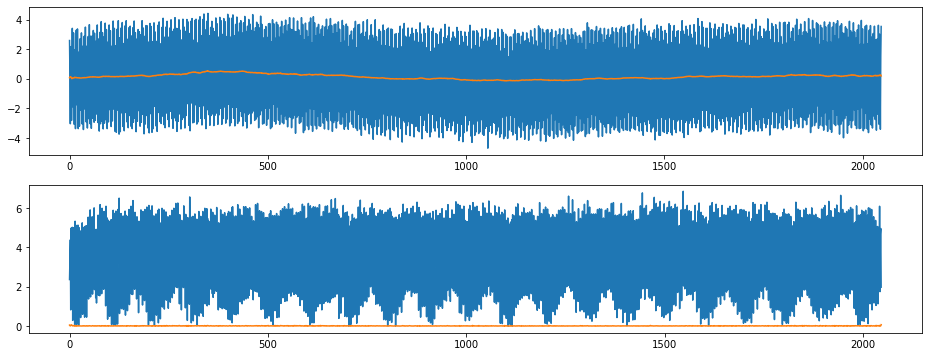

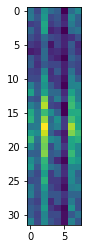

index:  107544
MAE:  2.3131237027258322
n_bunches         64
bunch_index     1788
bunch_number      30
Name: 10073111, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7427/instability_data/07427_Inst_B1H_Q7_20181108_20h39m14s.h5


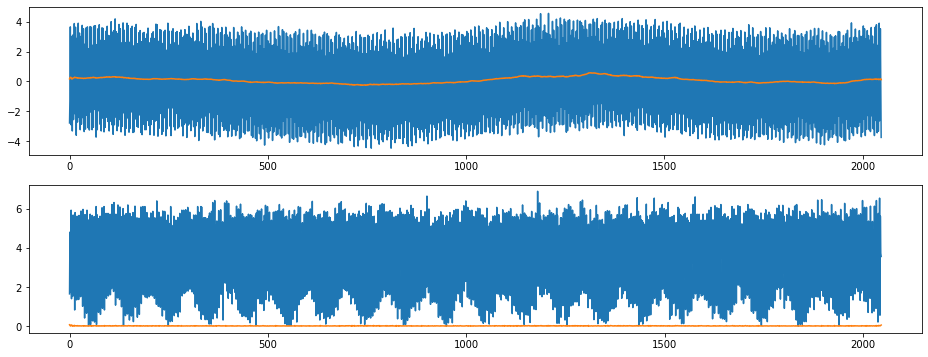

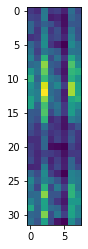

index:  114667
MAE:  2.312879935197551
n_bunches        286
bunch_index     2213
bunch_number     227
Name: 5532548, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/instability_data/06984_Inst_B1H_Q7_20180726_22h15m14s.h5


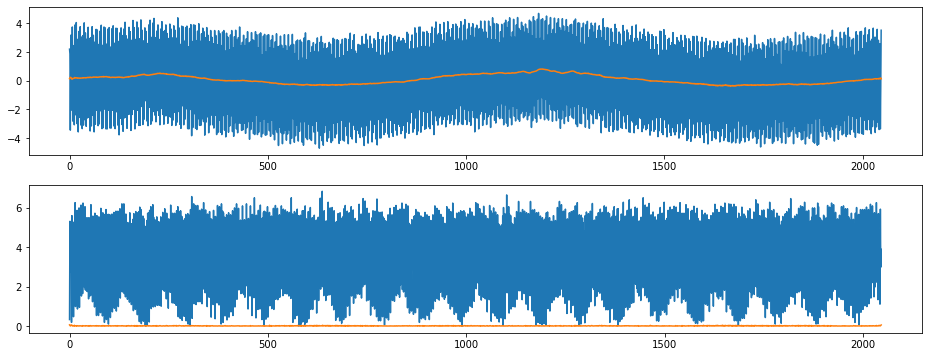

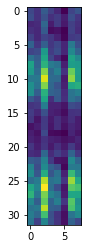

index:  198200
MAE:  2.1963514695110247
n_bunches       1887
bunch_index      882
bunch_number     452
Name: 10719668, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_12h22m14s.h5


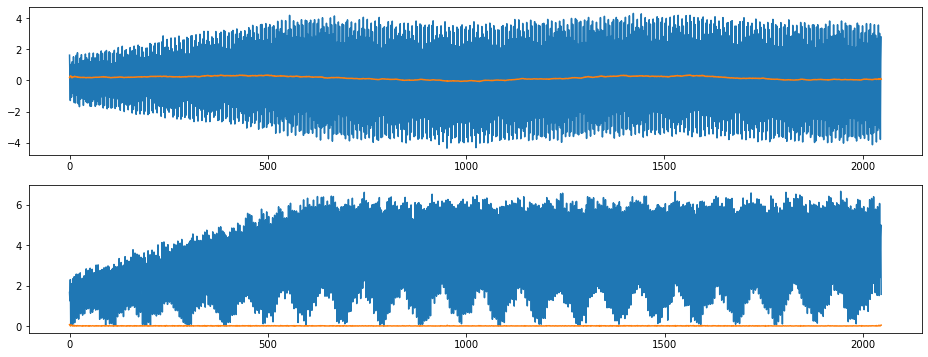

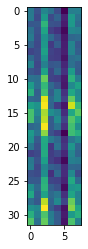

index:  369077
MAE:  2.1260510993392776
n_bunches       2556
bunch_index     1779
bunch_number    1305
Name: 6139861, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_15h04m14s.h5


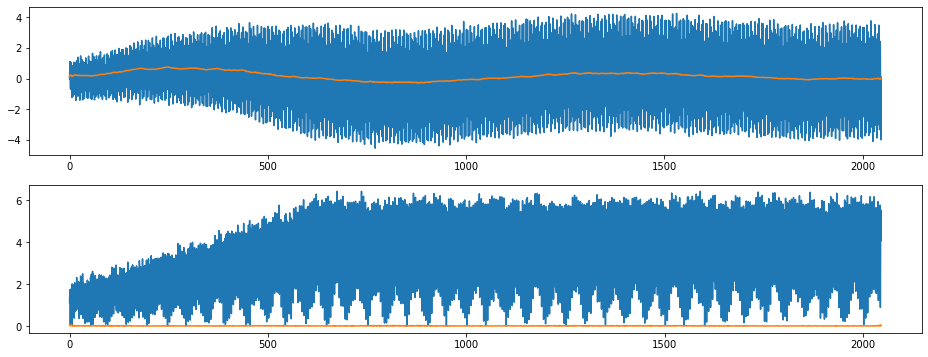

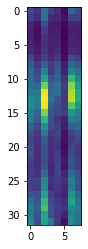

index:  148384
MAE:  2.1159900636175077
n_bunches       229
bunch_index     739
bunch_number    157
Name: 10429515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_16h50m51s.h5


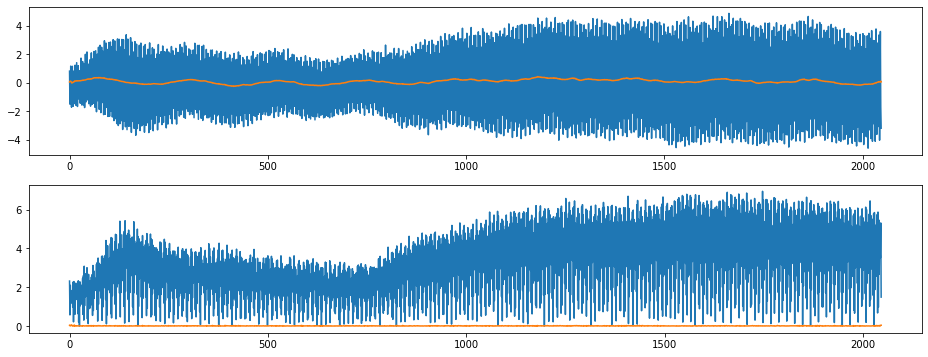

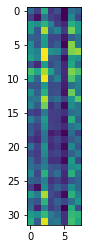

index:  390530
MAE:  2.1091318719540793
n_bunches       780
bunch_index     647
bunch_number    463
Name: 5414606, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7090/instability_data/07090_Inst_B1H_Q7_20180826_10h13m14s.h5


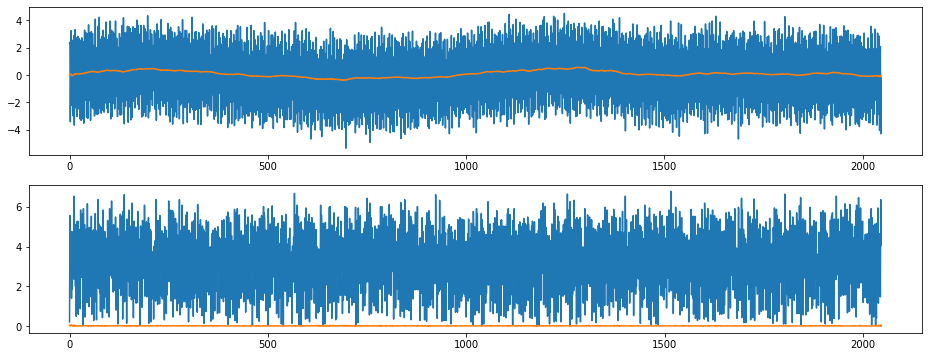

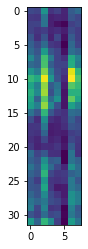

index:  402738
MAE:  2.104365567090965
n_bunches        376
bunch_index     3015
bunch_number     365
Name: 9551471, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_02h53m13s.h5


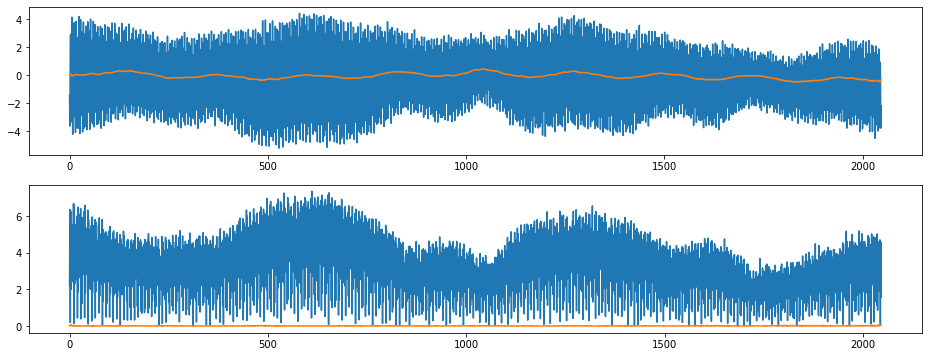

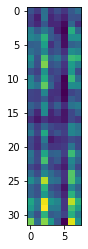

index:  388901
MAE:  2.084050481319817
n_bunches       780
bunch_index     372
bunch_number    188
Name: 1592957, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_16h07m17s.h5


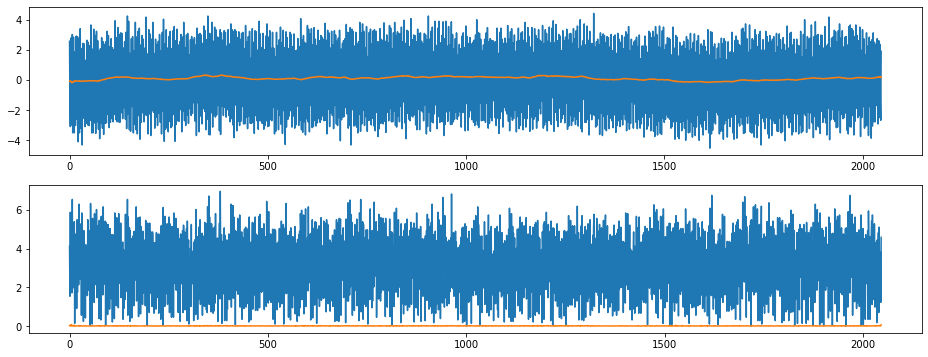

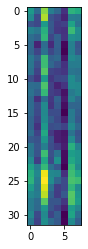

index:  390135
MAE:  2.0809004957415462
n_bunches       1068
bunch_index      290
bunch_number     177
Name: 7327762, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6702/instability_data/06702_Inst_B1H_Q7_20180519_21h58m48s.h5


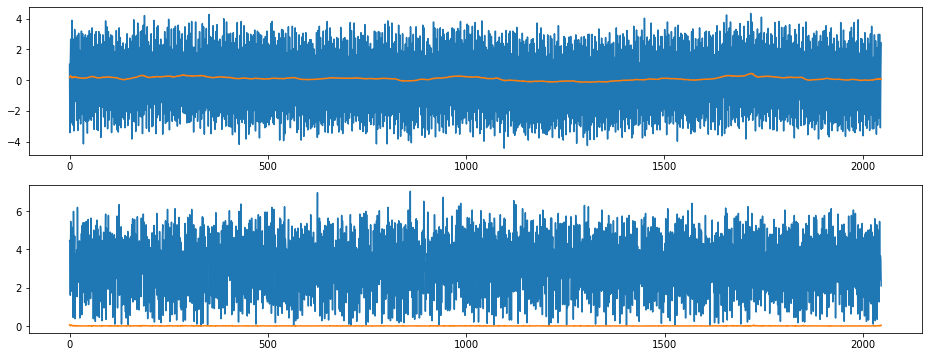

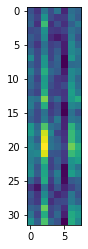

index:  92513
MAE:  2.0694037434993664
n_bunches        648
bunch_index     1152
bunch_number     211
Name: 241649, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h16m16s.h5


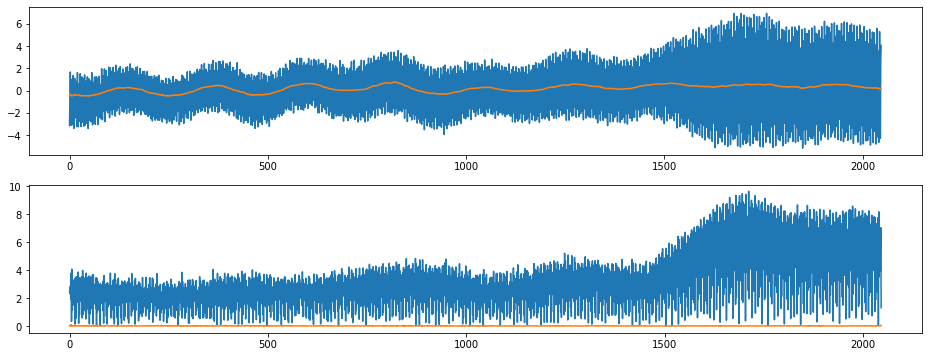

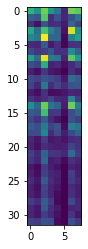

index:  343471
MAE:  2.0206361493993157
n_bunches        796
bunch_index     1371
bunch_number     755
Name: 8864060, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h42m14s.h5


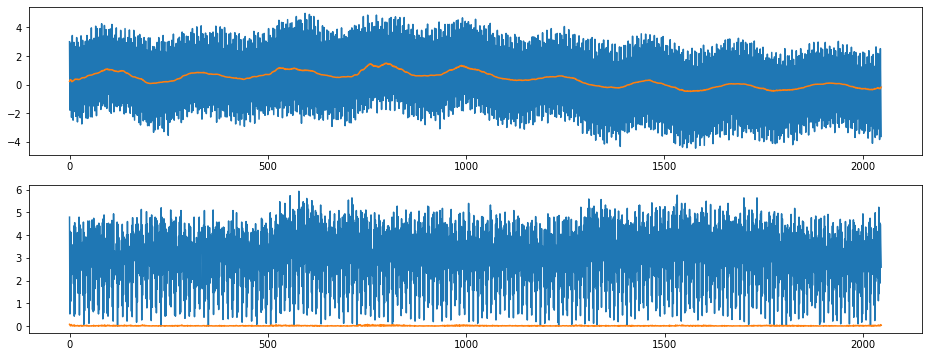

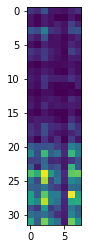

index:  339513
MAE:  1.9697839347272363
n_bunches       2556
bunch_index       46
bunch_number       9
Name: 5694496, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_06h48m14s.h5


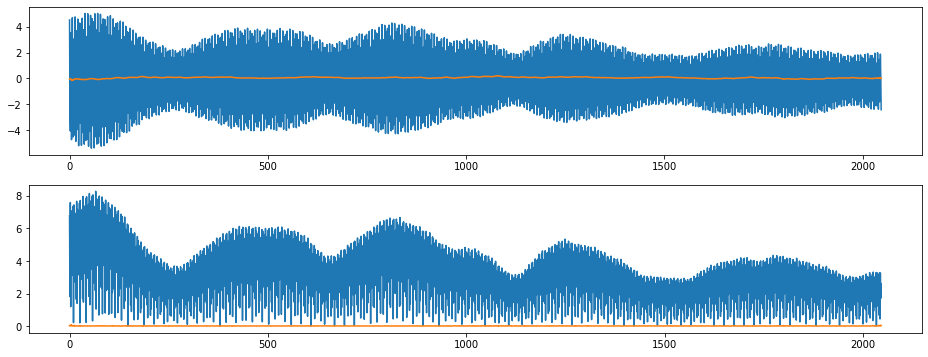

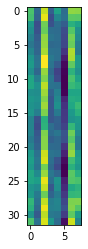

index:  109843
MAE:  1.9418398326410231
n_bunches        648
bunch_index     2093
bunch_number     390
Name: 9250600, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_00h49m15s.h5


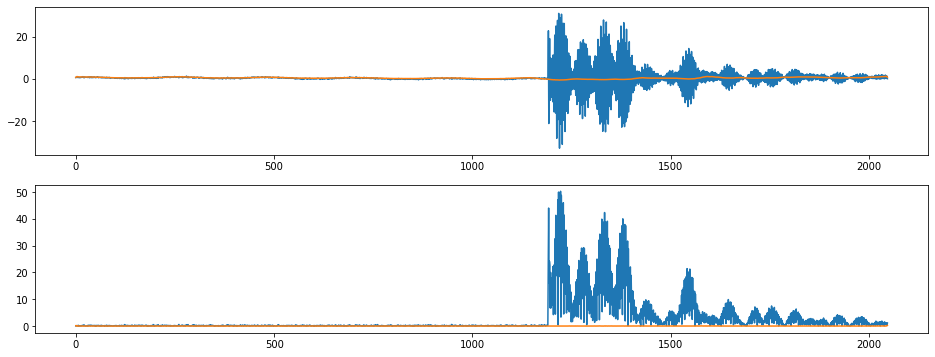

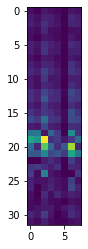

index:  386905
MAE:  1.9250722584937878
n_bunches       1868
bunch_index     3174
bunch_number    1711
Name: 4273251, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6278/instability_data/06278_Inst_B1H_Q7_20171007_00h03m15s.h5


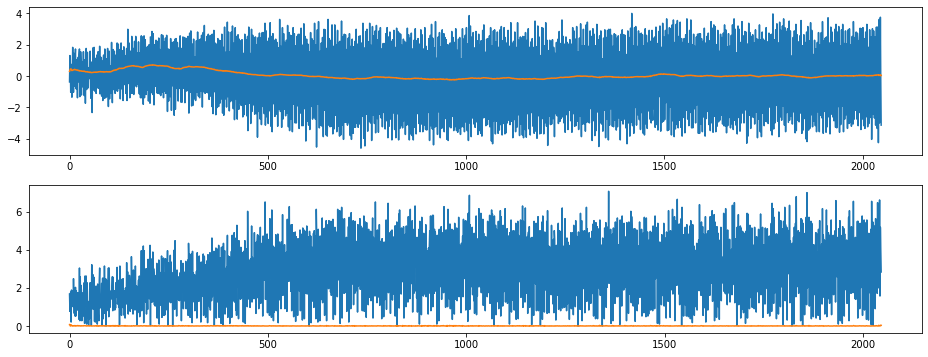

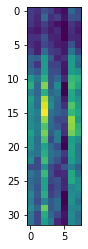

index:  299146
MAE:  1.8348211391433478
n_bunches       108
bunch_index      82
bunch_number     33
Name: 3221962, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7139/instability_data/07139_Inst_B1H_Q7_20180908_18h06m51s.h5


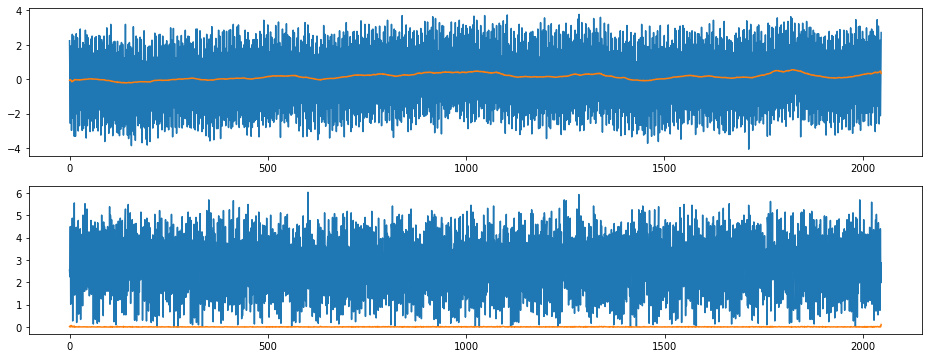

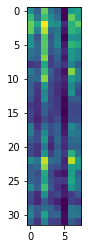

index:  296348
MAE:  1.8238012328884499
n_bunches        924
bunch_index     1141
bunch_number     813
Name: 5111519, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6687/instability_data/06687_Inst_B1H_Q7_20180515_16h04m40s.h5


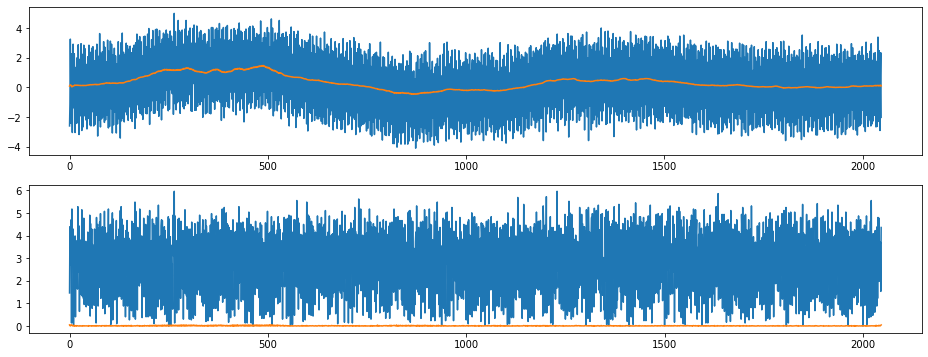

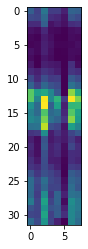

index:  95479
MAE:  1.815534499126417
n_bunches       1868
bunch_index      595
bunch_number     315
Name: 597472, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_01h54m14s.h5


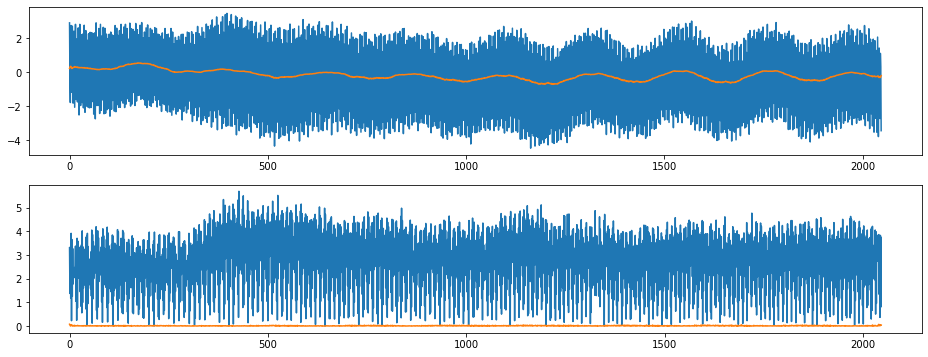

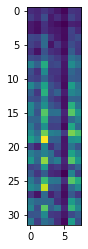

index:  299765
MAE:  1.8119414415488908
n_bunches        987
bunch_index     1357
bunch_number     382
Name: 11658543, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h33m14s.h5


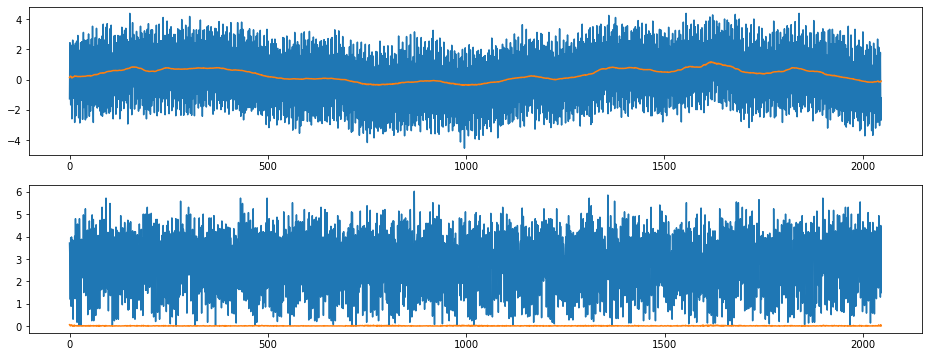

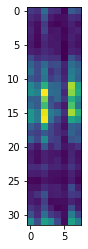

index:  338029
MAE:  1.8093750254878445
n_bunches       168
bunch_index     356
bunch_number     93
Name: 3879488, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6850/instability_data/06850_Inst_B1H_Q7_20180626_20h01m31s.h5


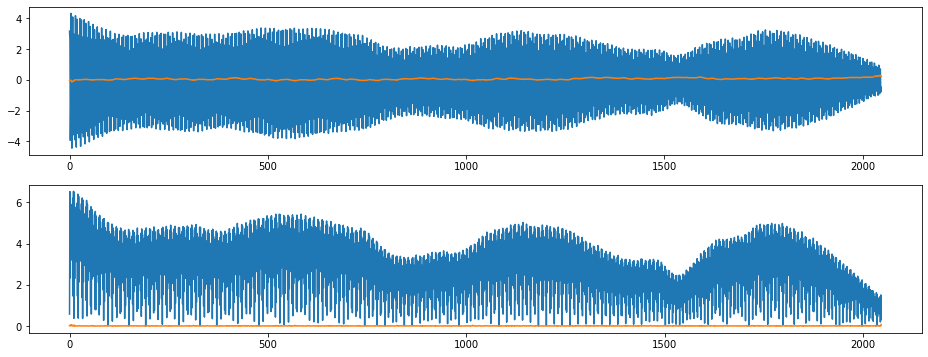

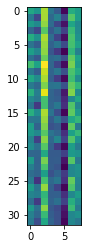

index:  296290
MAE:  1.8058691466710373
n_bunches       252
bunch_index     225
bunch_number    119
Name: 3214823, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6687/instability_data/06687_Inst_B1H_Q7_20180515_15h56m24s.h5


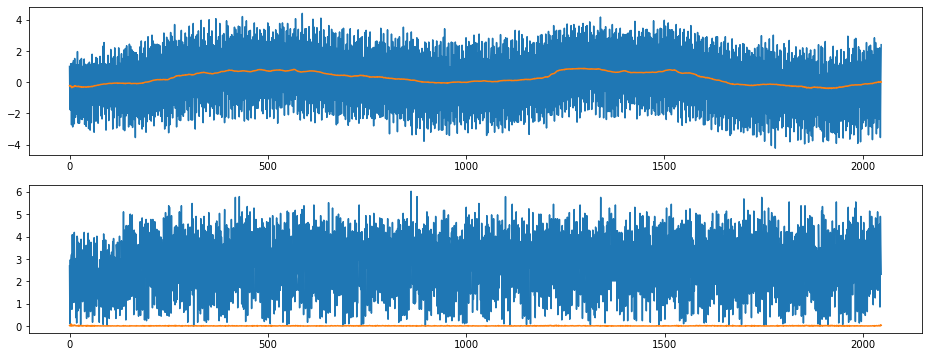

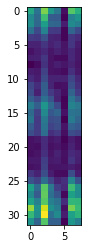

index:  244599
MAE:  1.792759069003584
n_bunches       2175
bunch_index     2061
bunch_number    1327
Name: 8796203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_12h23m13s.h5


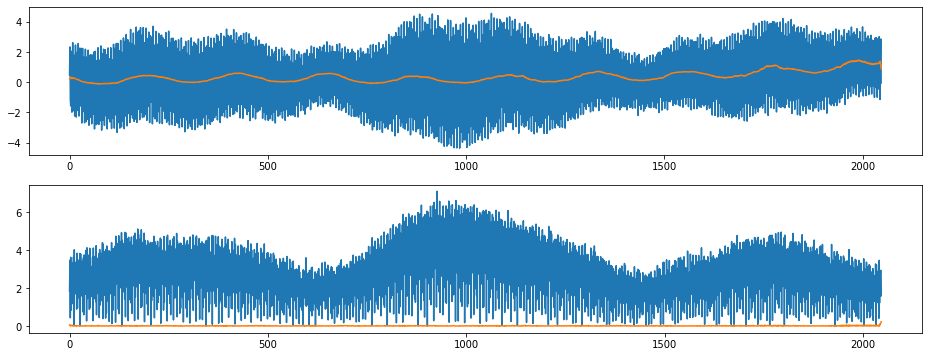

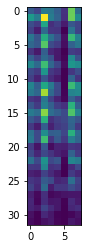

index:  295738
MAE:  1.781221052565016
n_bunches       1227
bunch_index     2066
bunch_number     766
Name: 427854, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_09h49m14s.h5


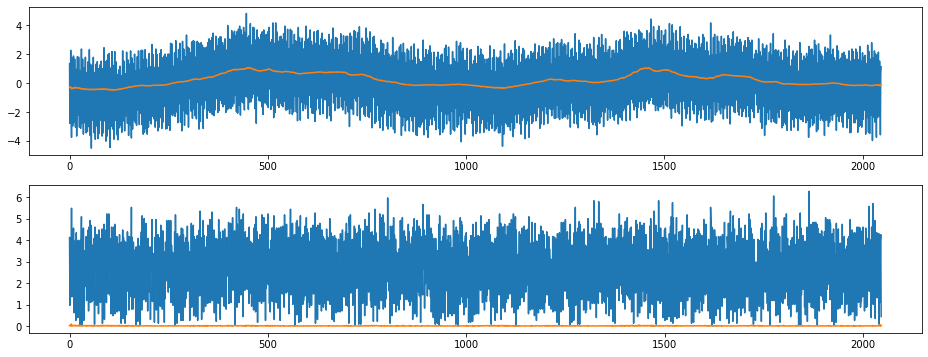

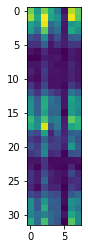

index:  336862
MAE:  1.780149639293339
n_bunches       1868
bunch_index     2815
bunch_number    1501
Name: 3102788, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_01h48m14s.h5


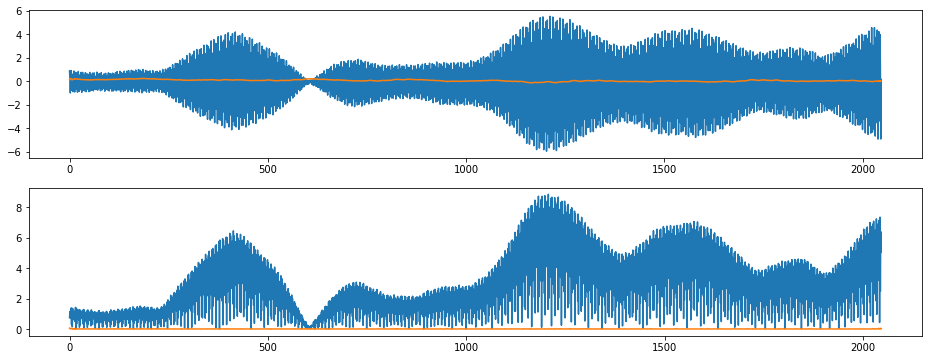

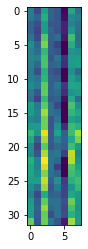

index:  298501
MAE:  1.7731596813879562
n_bunches       924
bunch_index     213
bunch_number    126
Name: 5876558, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7069/instability_data/07069_Inst_B1H_Q7_20180820_02h24m14s.h5


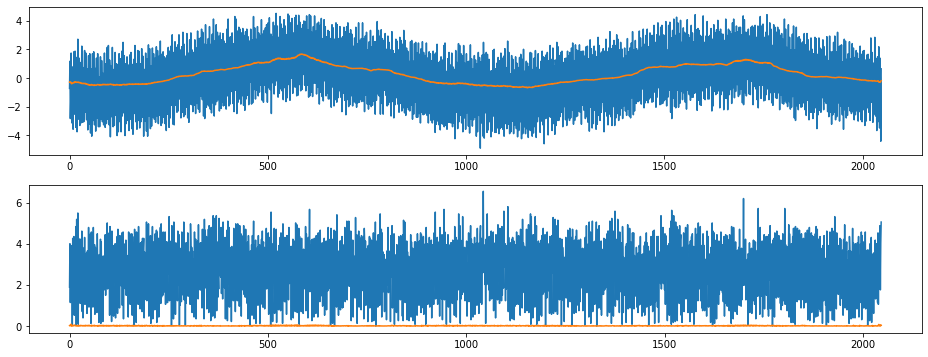

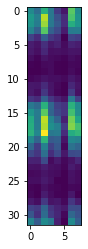

index:  297863
MAE:  1.7657145239630423
n_bunches       1292
bunch_index     3402
bunch_number    1288
Name: 3207340, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h09m14s.h5


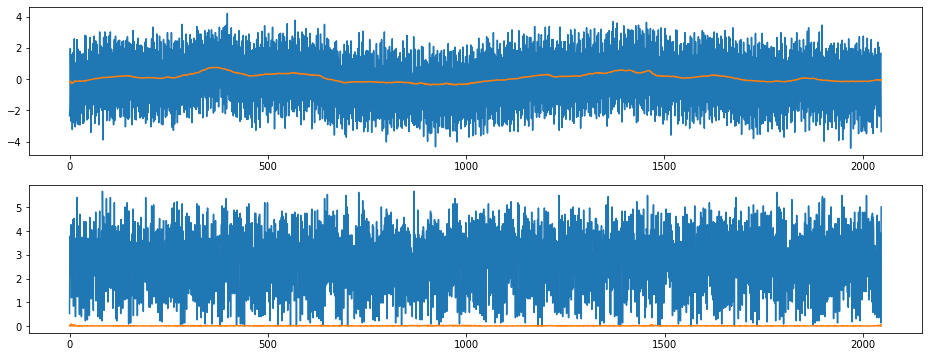

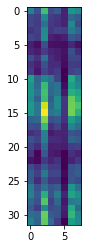

index:  51787
MAE:  1.7542116516978141
n_bunches       408
bunch_index     895
bunch_number     28
Name: 3999155, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_04h33m37s.h5


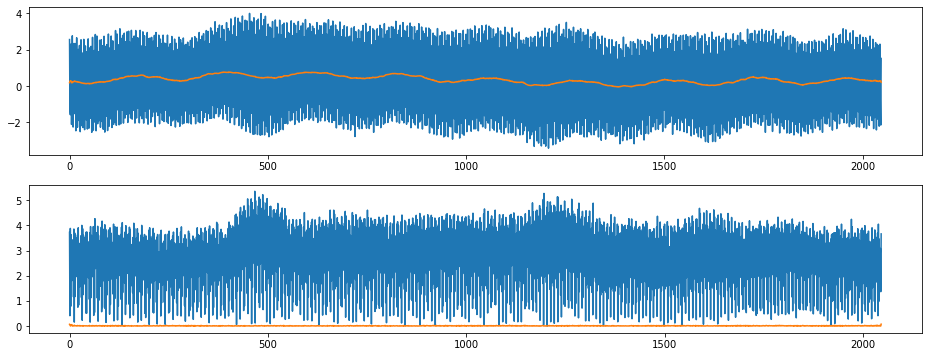

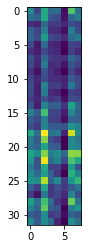

index:  240063
MAE:  1.747907177209781
n_bunches       2556
bunch_index     3334
bunch_number    2484
Name: 7263329, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_22h11m14s.h5


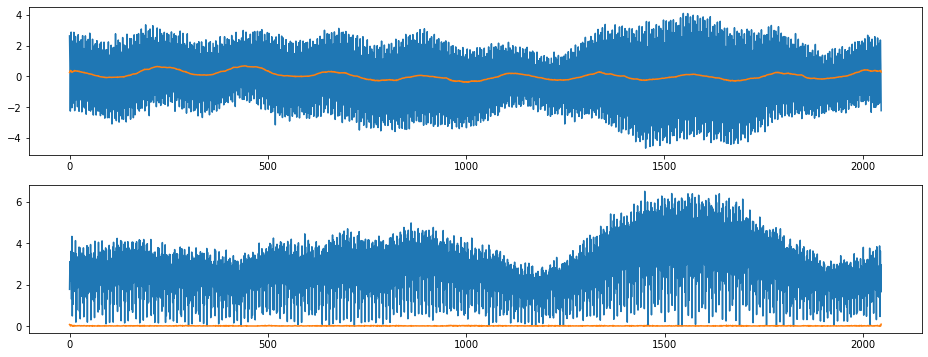

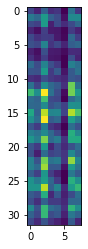

index:  383328
MAE:  1.7219802100691357
n_bunches        652
bunch_index     1094
bunch_number     585
Name: 9155007, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6278/instability_data/06278_Inst_B1H_Q7_20171006_23h02m07s.h5


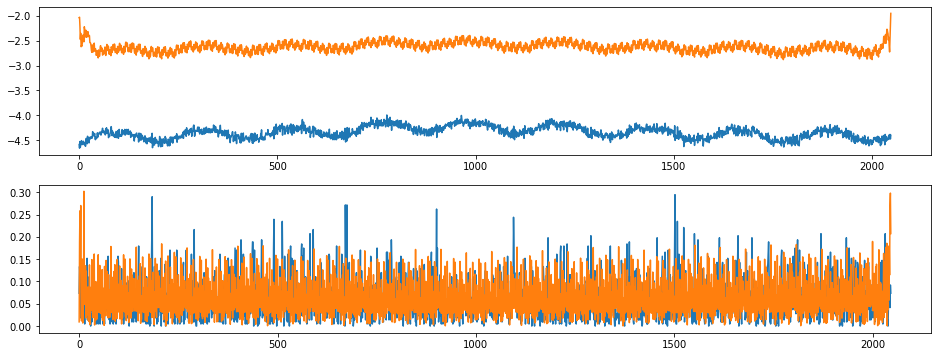

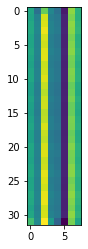

index:  409572
MAE:  1.6616885913455857
n_bunches       636
bunch_index     795
bunch_number    569
Name: 6952398, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7043/instability_data/07043_Inst_B1H_Q7_20180811_08h46m32s.h5


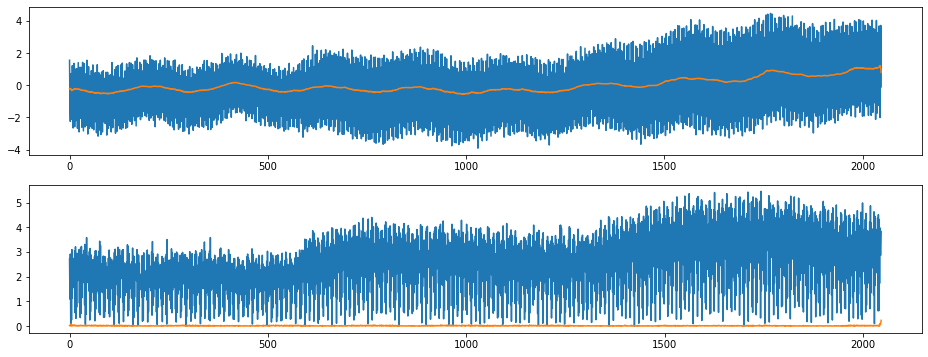

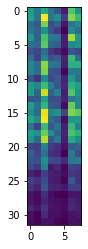

index:  94285
MAE:  1.6421929759584453
n_bunches       1868
bunch_index     2757
bunch_number    1482
Name: 2804483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_11h39m13s.h5


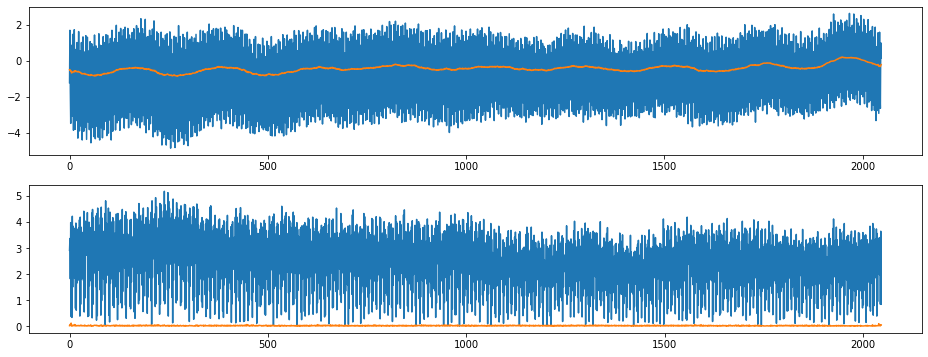

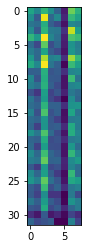

index:  336042
MAE:  1.638947509352829
n_bunches       444
bunch_index     930
bunch_number    155
Name: 10176778, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6728/instability_data/06728_Inst_B1H_Q7_20180526_14h55m14s.h5


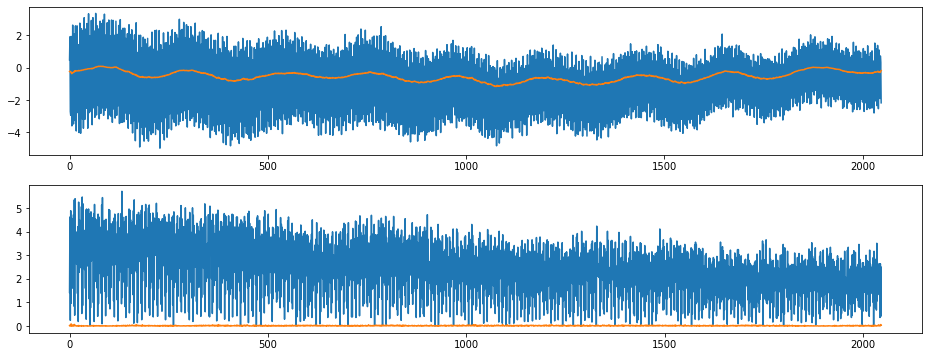

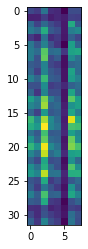

index:  55581
MAE:  1.6319498476198966
n_bunches       1916
bunch_index     2707
bunch_number    1486
Name: 8934200, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_09h49m15s.h5


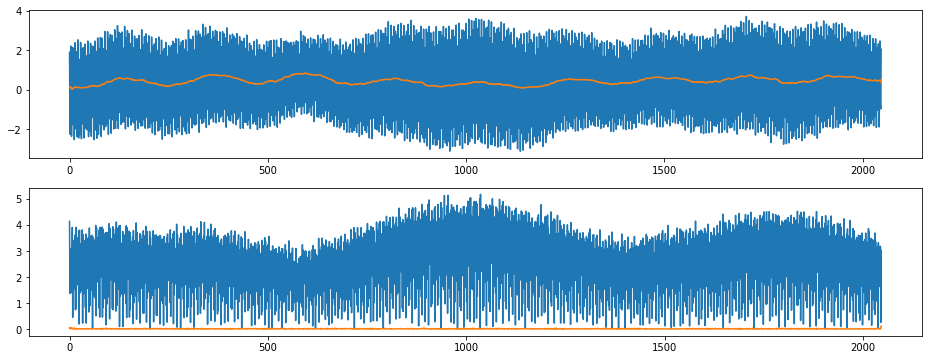

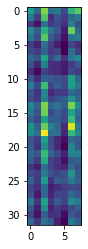

index:  51942
MAE:  1.6255781060336025
n_bunches       636
bunch_index     301
bunch_number    188
Name: 5634789, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6765/instability_data/06765_Inst_B1H_Q7_20180607_13h48m28s.h5


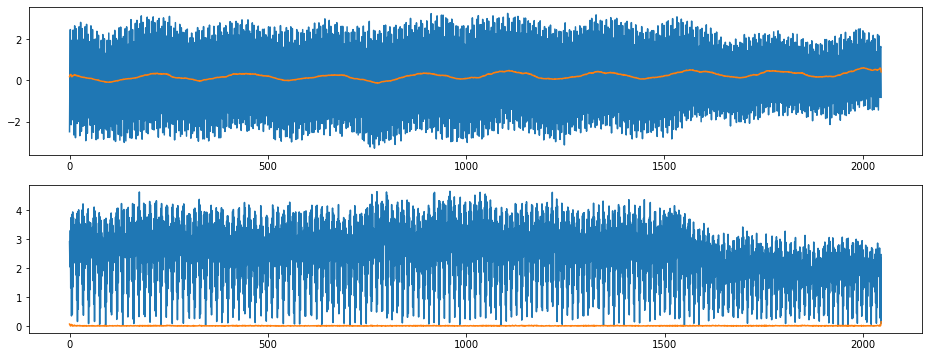

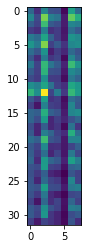

index:  195040
MAE:  1.6067292287356263
n_bunches       1868
bunch_index     2918
bunch_number    1566
Name: 6982418, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_19h00m14s.h5


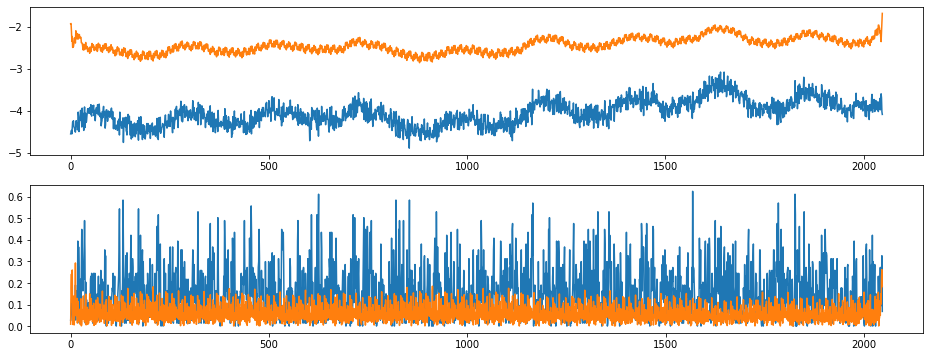

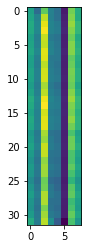

index:  291213
MAE:  1.6008153452234253
n_bunches        987
bunch_index     2344
bunch_number     702
Name: 9193929, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_22h27m14s.h5


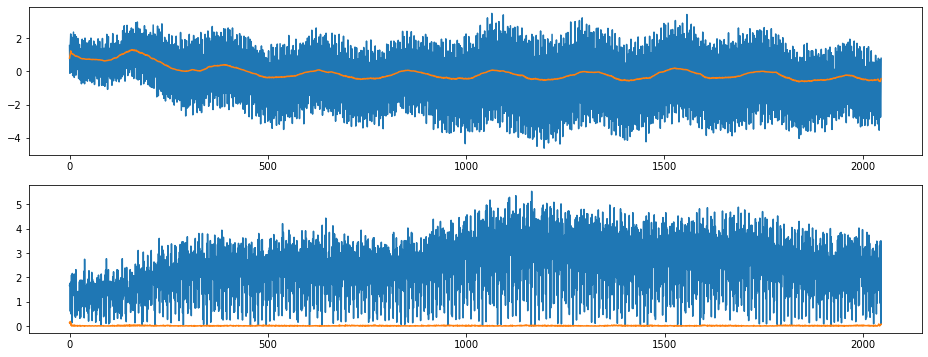

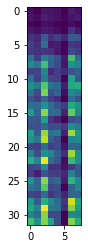

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()